This code was based on in the following references:

[1] "Particle Swarm Optimization" published in 1995 by James Kennedy and Russell Eberhart

[2] "A New Optimizer Using Particle Swarm Theory" published in 1995 by James Kennedy and Russell Eberhart

[3] "A Novel Search Algorithm based on Fish School Behavior" published in 2008 by Bastos Filho, Lima Neto, Lins, D. O. Nascimento and P. Lima

[4] "An Enhanced Fish School Search Algorithm" published in 2013 by Bastos Filho and  D. O. Nascimento

[5] "Defining a Standard for Particle Swarm Optimization" published in 2007 by Bratton and Kennedy

signal ranked wilcoxon non-parametrical test

https://ieeexplore.ieee.org/document/8790158

https://arxiv.org/abs/2201.00523

https://titan.csit.rmit.edu.au/~e46507/cec13-niching/competition/cec2013-niching-benchmark-tech-report.pdf

### Imports

In [ ]:
import os
import sys
import csv
import random
import copy
import math
import time
import datetime
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy.stats as sts
from random import randint
from IPython.display import display, HTML
from google.colab import drive, files
%matplotlib inline
plt.rcParams["figure.figsize"] = (18,9)

### Connection with Google Drive

In [ ]:
drive.mount('/content/drive', force_remount=True) #  Connect to drive
FOLDERNAME = 'POLI/decimo/tcc/Algoritms/Results/' #  Set folder that have the datasts
assert FOLDERNAME is not None, "[!] Enter the foldername."
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME)) #  Locale the foldeer

%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/POLI/decimo/tcc/Algoritms/Results


### Validation 30 bests execution of each algoritms

Get files CVSs that contains informations about many executions that have the bests values found by each algoritm. The algoritms are PSO, GWO and FSS and they has 30 execution with 1K iterations for the same objective functions with the same dimention.

- `Colocar escalas nos gráficos unificados`
- `Reajustar as escalas de log que estão quebrando` (https://stackoverflow.com/questions/16904755/logscale-plots-with-zero-values-in-matplotlib)
- `Adição de dimensão 50 e 100`
- `Adaptar convergencia para apenas na hora de apresentar tentar permanecer com o minimo até que tenha outro minimo (melhor que ele) encontrado`
- `Adição novamente do PSO (revisão de Rodrigo)`
- Wilcoxon para explicar melhor os resultados obtidos nele (reunião com Rodrigo)

In [ ]:
optimizers = ["PSO", "FSS", "GWO", "VGWO"]
files_100 = []
files_50 = []
files_30 = []
files_15 = []
filepath = os.path.dirname(os.path.abspath('Results'))
for opt in optimizers:
  filename = f"{filepath}/100d/{opt}_exec.csv"
  df = pd.read_csv(filename)
  files_100.append(df)
  filename = f"{filepath}/50d/{opt}_exec.csv"
  df = pd.read_csv(filename)
  files_50.append(df)
  filename = f"{filepath}/30d/{opt}_exec.csv"
  df = pd.read_csv(filename)
  files_30.append(df)
  filename = f"{filepath}/15d/{opt}_exec.csv"
  df = pd.read_csv(filename)
  files_15.append(df)

results_15 = pd.concat(files_15)
results_15.sort_values(by=['func'], ascending=False)
results_30 = pd.concat(files_30)
results_30.sort_values(by=['func'], ascending=False)
results_50 = pd.concat(files_50)
results_50.sort_values(by=['func'], ascending=False)
results_100 = pd.concat(files_100)
results_100.sort_values(by=['func'], ascending=False)
results = {15: results_15, 30: results_30, 50: results_50, 100: results_100}
results[30].head(5)

,opt,func,exec_time,run1,run2,run3,run4,run5,run6,run7,...,run21,run22,run23,run24,run25,run26,run27,run28,run29,run30
0,PSO,Sphere,114.754664,3.506104e-15,1.129840e-13,6.893224e-14,1.783547e-14,3.299552e-13,1.417080e-14,2.740888e-11,...,2.440454e-12,3.684364e-12,6.219202e-12,3.001609e-13,10000.000000,5.493831e-15,4.199519e-14,2.127722e-13,4.529366e-10,3.218032e-11
1,PSO,RotatedHyperEllipsoid,322.790878,2.038720e-12,2.334594e-10,3.006477e+04,3.435974e+04,1.276152e-13,1.548032e-14,1.288490e+04,...,3.853790e-12,4.005823e-14,8.589935e+03,4.724464e+04,30064.771072,8.395106e-14,6.490216e-13,2.250633e-10,8.589935e+03,1.288490e+04
2,PSO,Rosenbrock,132.957713,1.569936e+01,2.432250e+02,6.996074e+01,7.205806e+01,2.732718e+01,9.002368e+04,9.268199e+00,...,9.007753e+04,9.476941e+01,2.412950e+02,2.545152e+02,127.391357,4.009828e+01,9.002397e+04,9.783501e+00,8.048897e+01,2.435744e+01
3,PSO,Dixon-Price,142.952326,2.643643e-13,1.210000e+02,1.210000e+02,3.140091e-03,5.938026e-03,1.210000e+02,8.100000e+01,...,8.100000e+01,3.169881e-10,1.646258e-09,1.210000e+02,121.000000,8.100000e+01,1.695519e-04,8.100000e+01,5.071577e-11,3.673279e-07
4,PSO,Perm,1383.793734,4.443655e-02,1.413842e+00,5.770915e-03,1.171012e-04,7.497035e-02,1.308982e-02,1.588368e-04,...,3.330895e+00,9.570190e+01,4.447584e+02,5.049034e-04,0.033636,6.022555e-05,2.413640e-01,4.821668e-02,4.570894e-05,1.263772e+00


We separete in each objective functions and comparete each algoritm to show the best score found in each execution. Unfortunately the PSO shows in many execution a big score, it became the GWO and FSS visualization difficult.

Functions w/ 15 dim


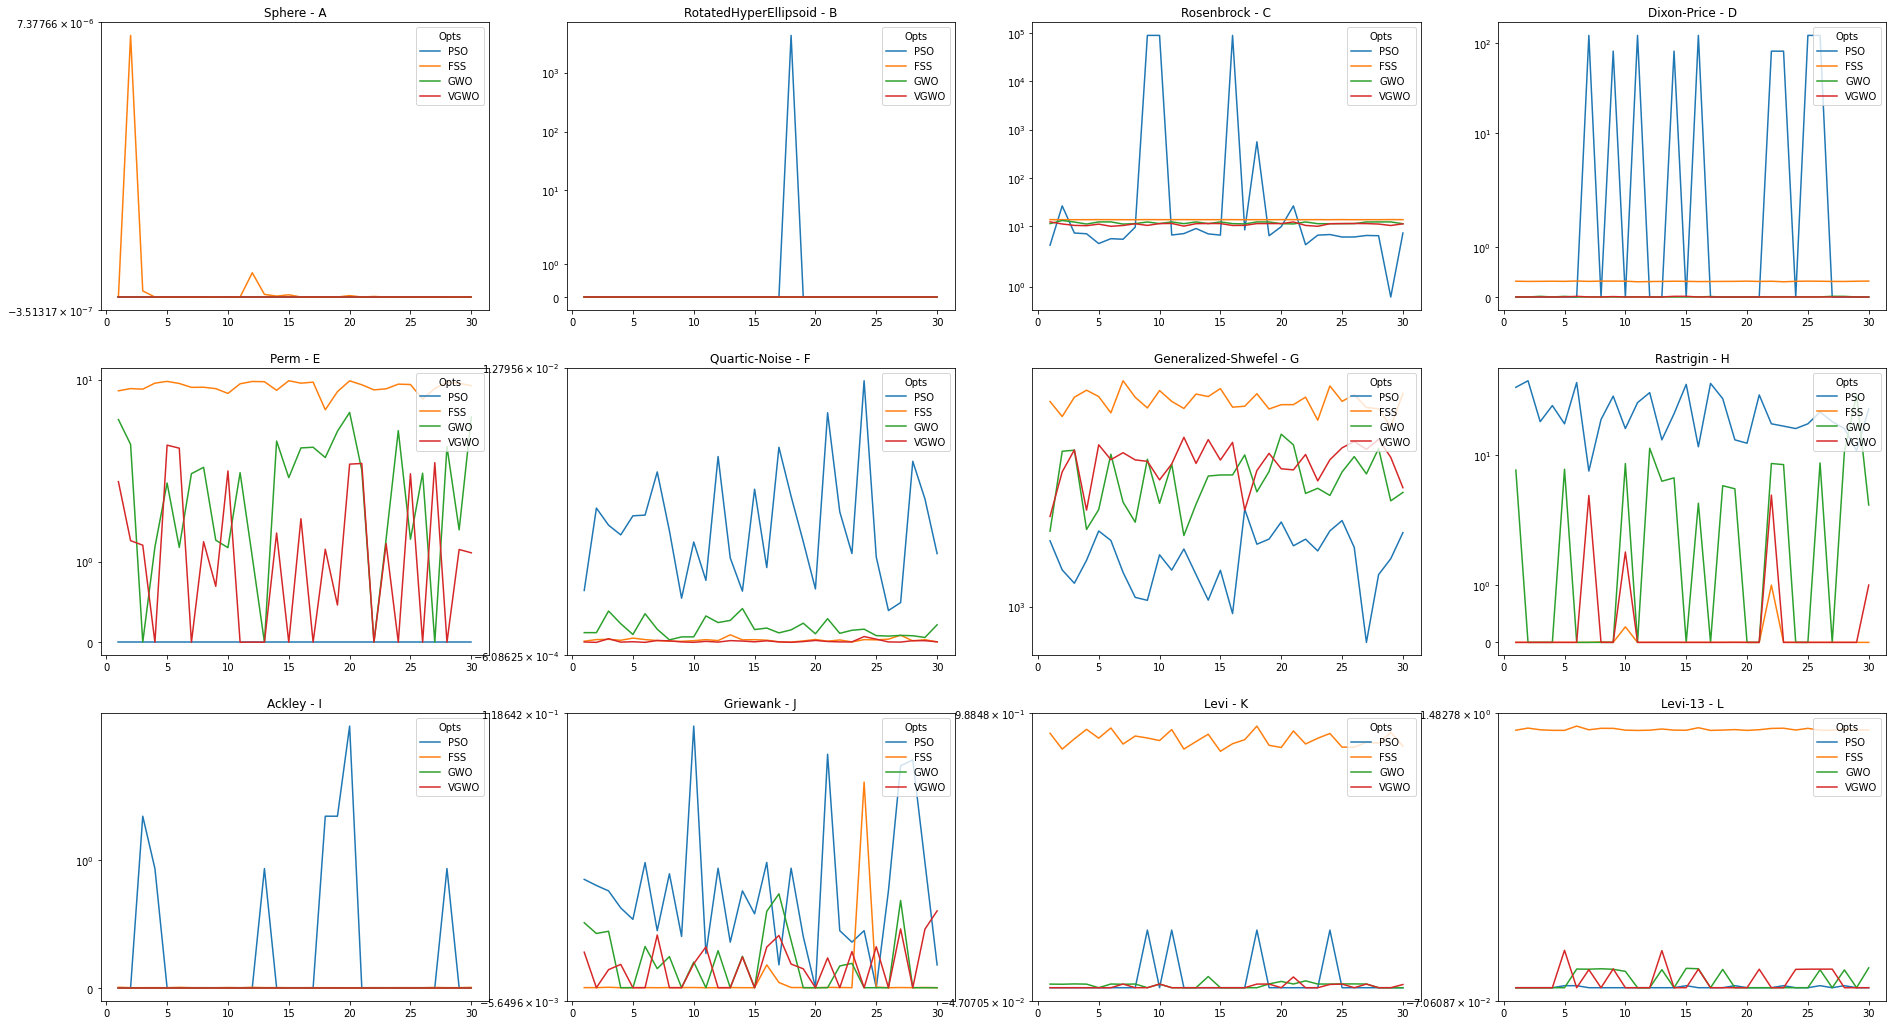

Functions w/ 30 dim


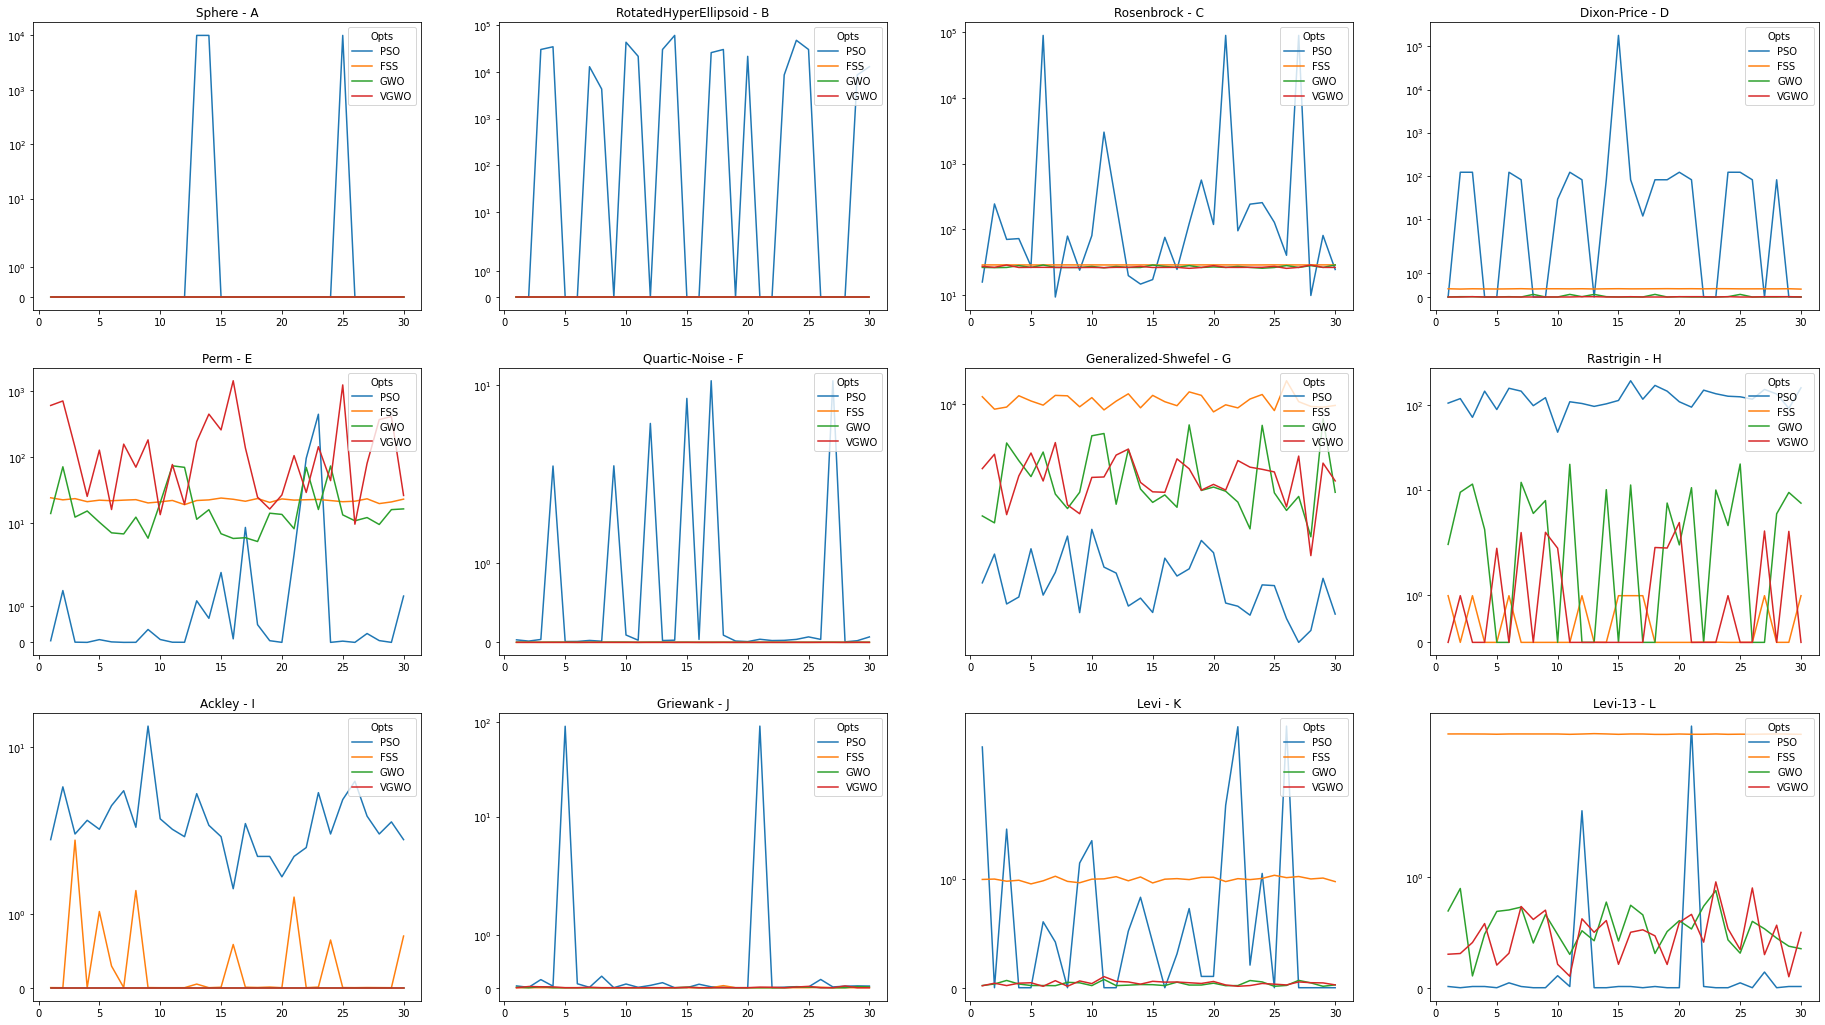

Functions w/ 50 dim


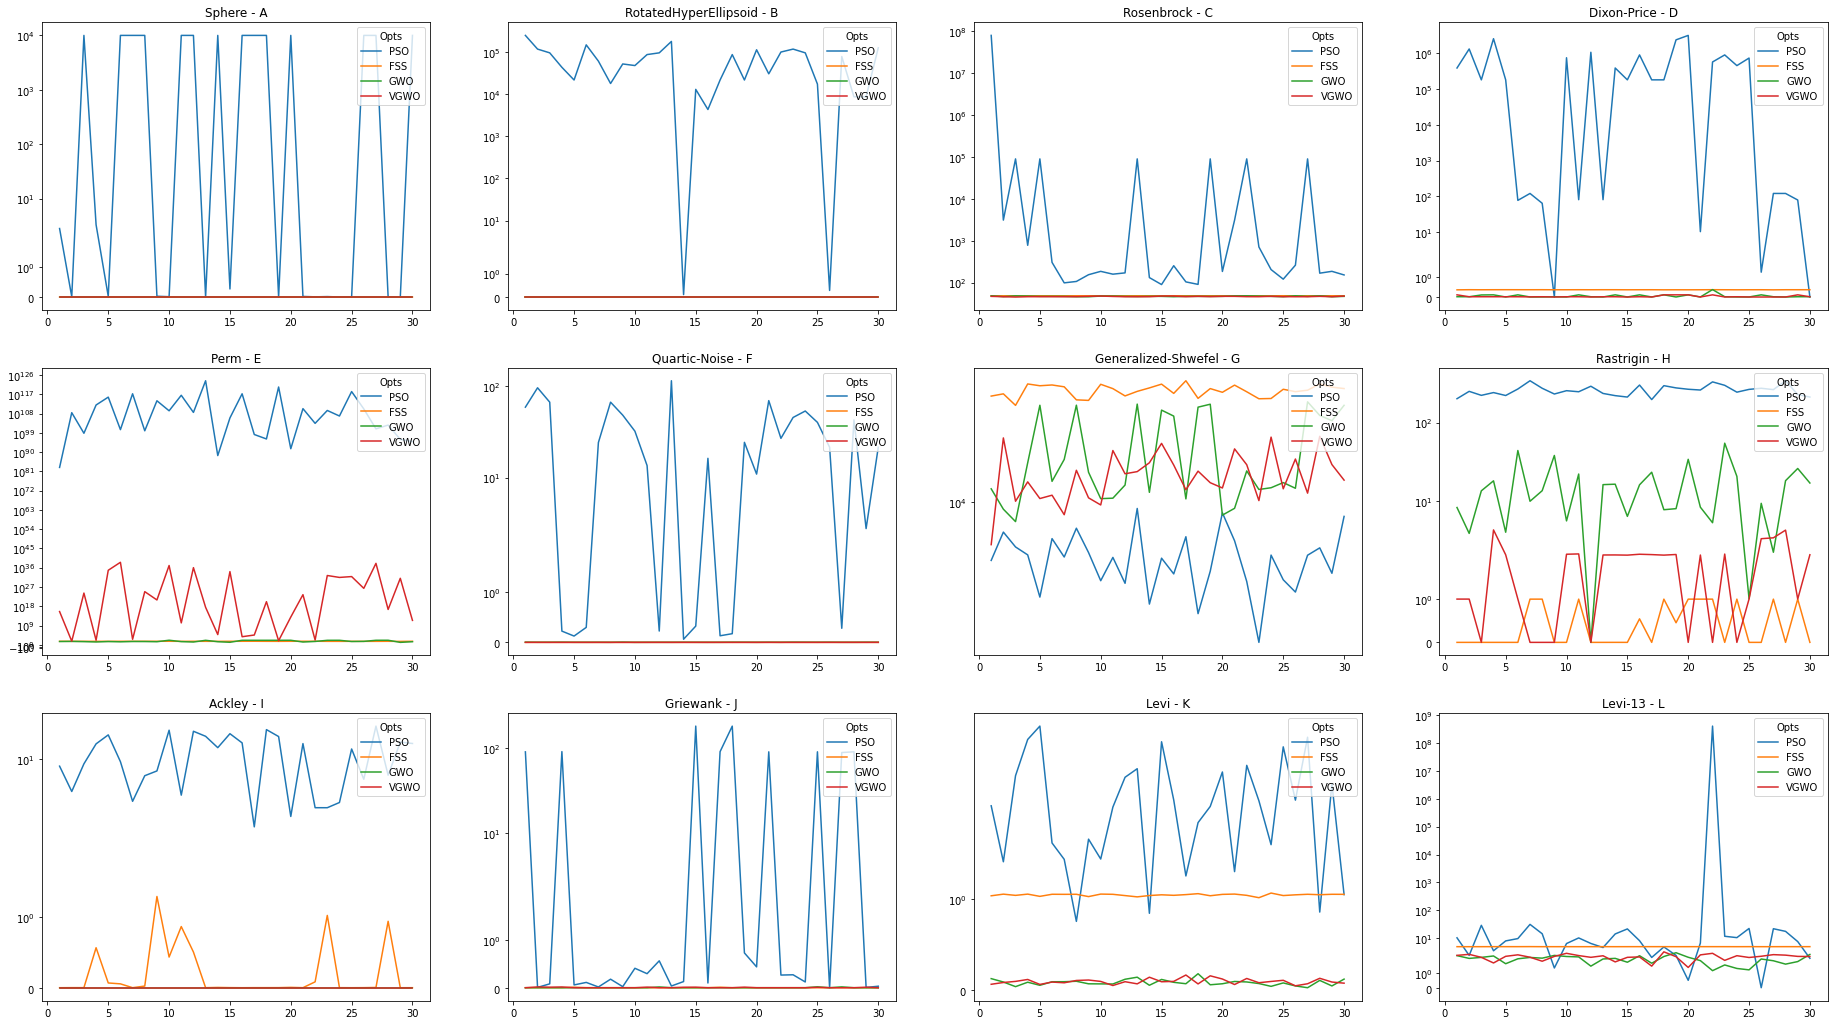

Functions w/ 100 dim


/usr/local/lib/python3.7/dist-packages/matplotlib/scale.py:496: RuntimeWarning: overflow encountered in power
  abs_a / self.linthresh - self._linscale_adj))


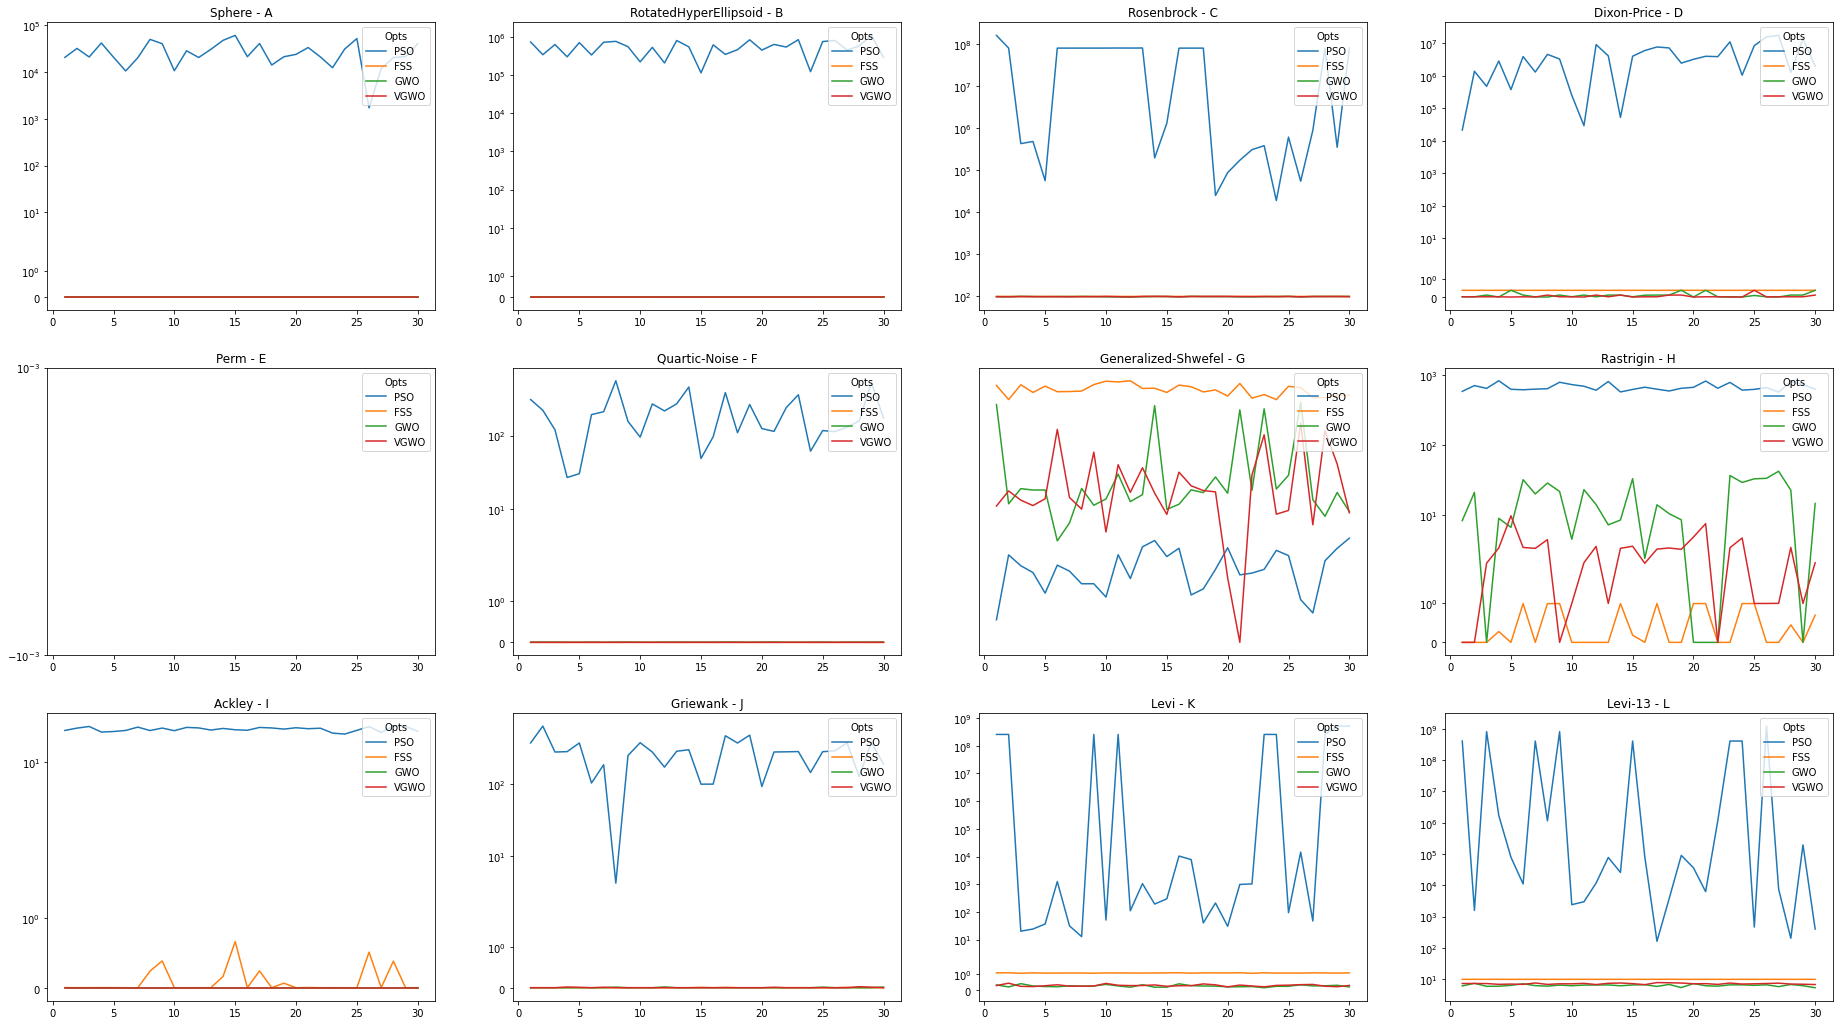

In [ ]:
plt.rcParams["figure.figsize"] = (32,18)
tb_dt = {}
for d in results:
  tb_dt[d] = {}
  objective_functions = results[d]['func'].unique().tolist()
  opts = results[d]['opt'].unique()
  print(f"Functions w/ {d} dim")
  for i, func in enumerate(objective_functions):
    tb_dt[d][func] = {}
    plt.subplot(3, 4, i+1)
    for o in opts:
      res = results[d][results[d]['func'] == func]
      res = res[res['opt'] == o].head(1)
      res = res.drop(['opt', 'func', 'exec_time'], axis=1)
      y = res.values.tolist()[0]
      y = [v if v < 999e+999 else 999e+999 for v in y]
      tb_dt[d][func][o] = y
      dt = pd.DataFrame(data=y, index=range(1, len(y)+1), columns=['score'])
      plt.plot(dt, label=o)
      plt.yscale('symlog')
      plt.legend(loc='upper right', title='Opts')
    plt.title(f"{func} - {string.ascii_uppercase[i]}")
  plt.show()

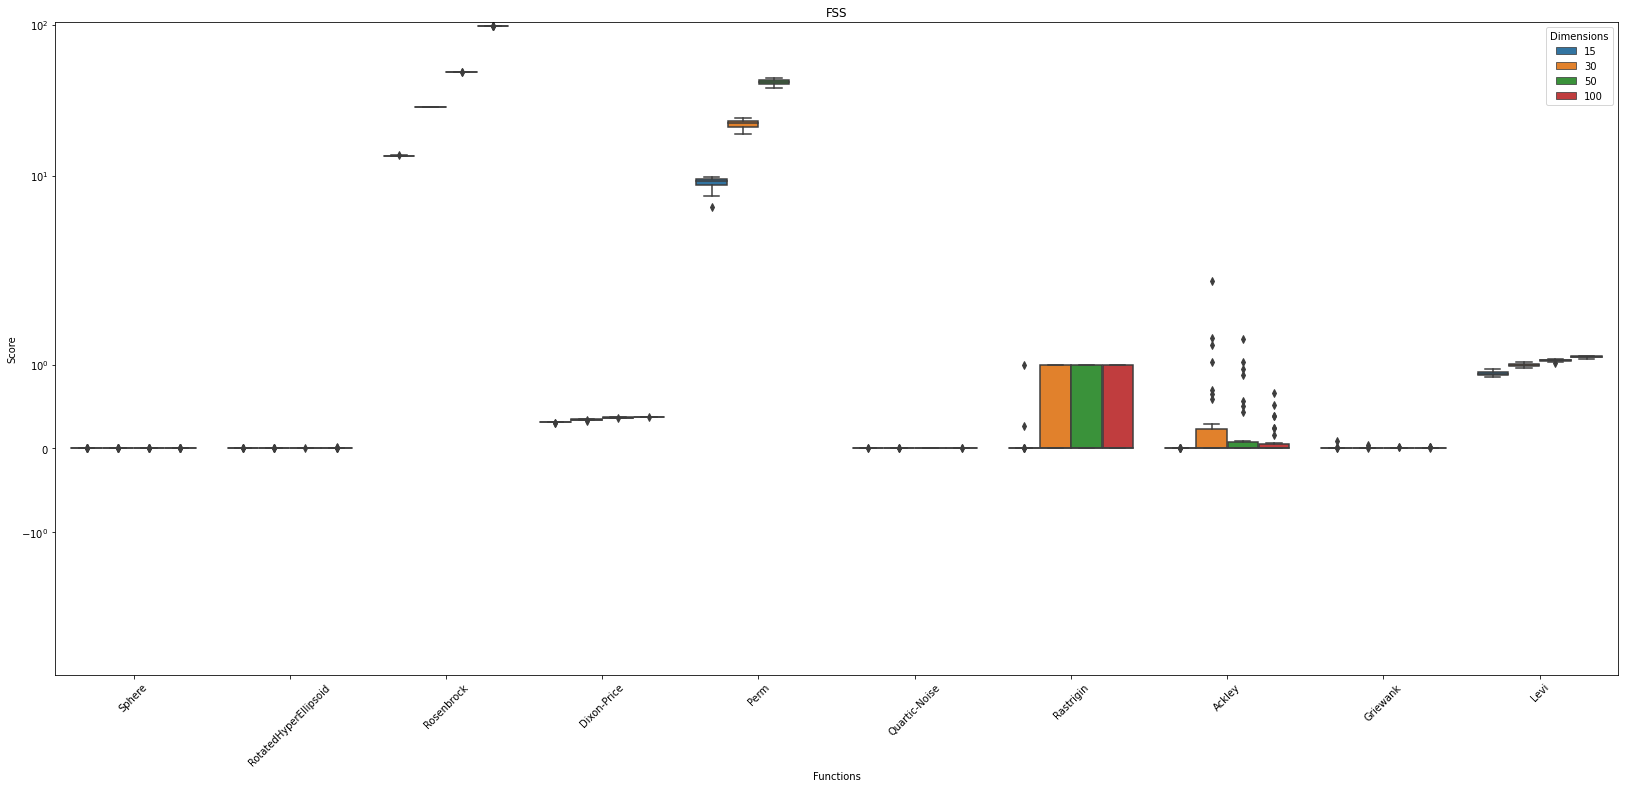

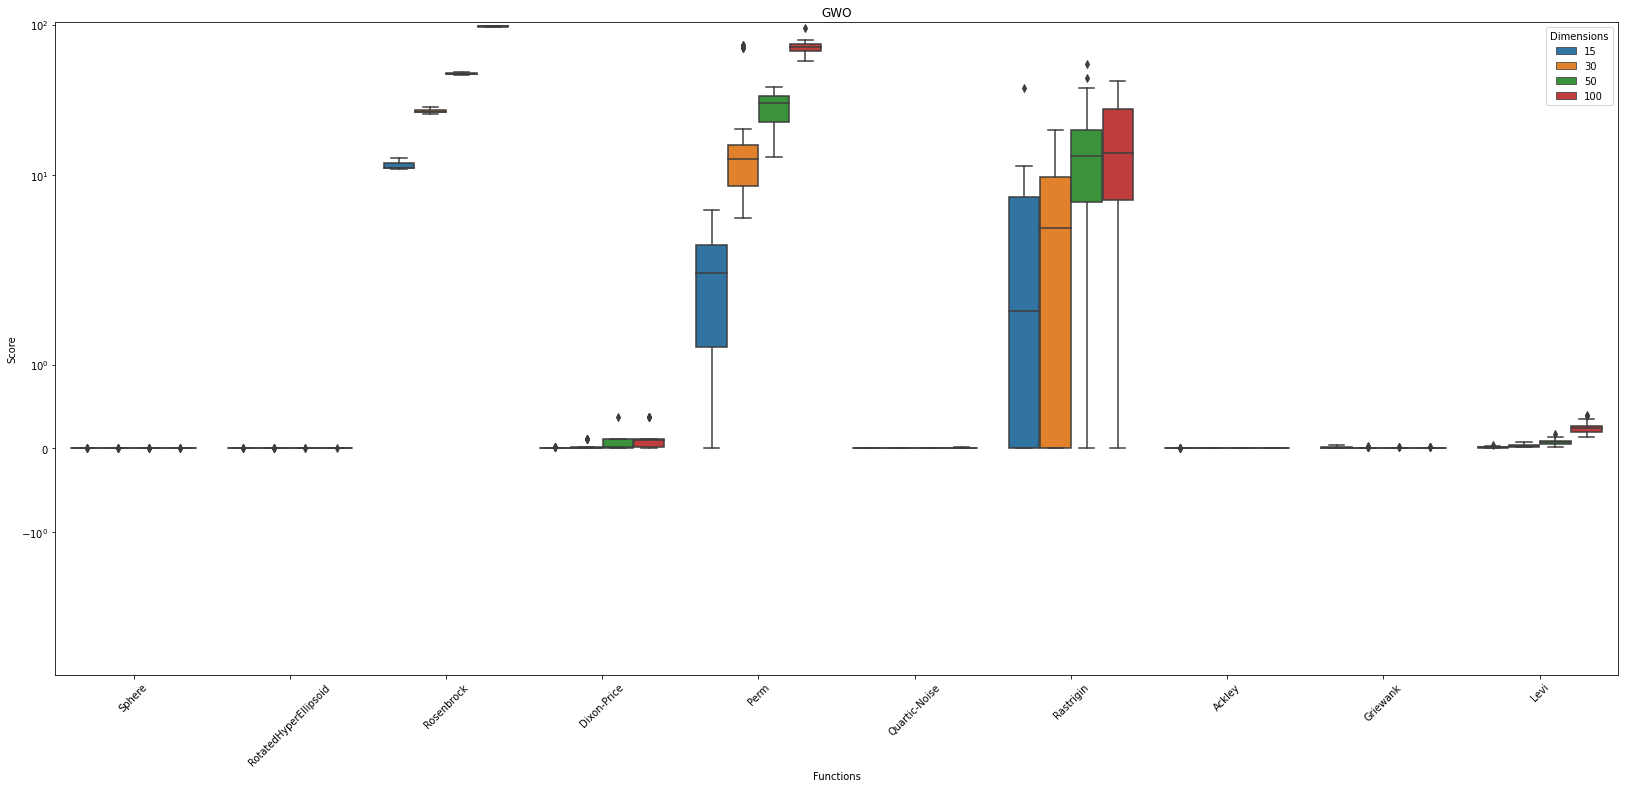

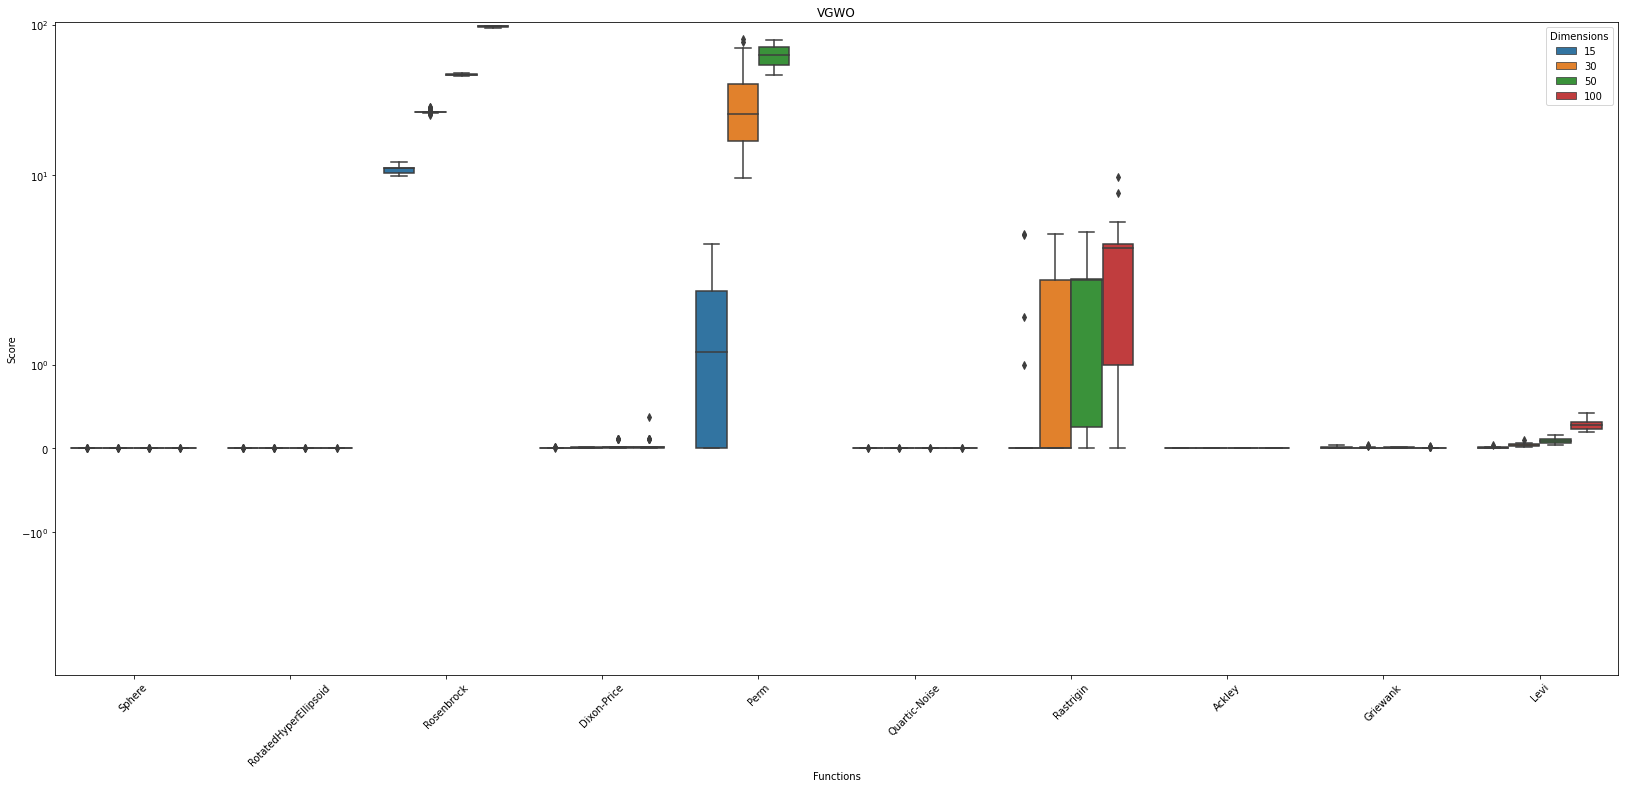

In [ ]:
plt.rcParams["figure.figsize"] = (28,12)
for opt in opts[1:]:
  obj_show = []
  for d in results:
    objective_functions = results[d]['func'].unique().tolist()
    objective_functions.remove('Levi-13')
    # objective_functions.remove('Perm')
    for func in objective_functions:
      res = results[d][results[d]['func'] == func]
      res = res[res['opt'] == opt].head(1)
      res = res.drop(['opt', 'func', 'exec_time'], axis=1)
      scores = res.values.tolist()[0]
      for s in scores:
        obj_show.append({'func': func, 'score': s, 'dim': d})

  res = pd.DataFrame(data=obj_show, index=range(len(obj_show)), columns=['func', 'score', 'dim'])
  res = res[res["score"] <= 100] # remove outliers
  ax = sns.boxplot(data=res, x='func', y='score', hue="dim")
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
  ax.set(xlabel='Functions', ylabel='Score', title=f"{opt}")
  plt.legend(loc='upper right', title='Dimensions')
  plt.yscale('symlog')
  plt.show()

In [ ]:
dt_func = []
for d in tb_dt:
  for func in tb_dt[d]:
    if func in ['Perm']:
      continue
    print(f"{func} w/ {d} dim")
    opts = list(tb_dt[d][func].keys())
    size_tb = len(tb_dt[d][func]["VGWO"])
    lines = [[tb_dt[d][func][o][i] for o in opts] for i in range(size_tb)]
    dt = pd.DataFrame(data=lines, index=range(1, len(tb_dt[d][func][o])+1), columns=opts)
    dt_func.append(dt)

    wil_pso_vgwo = sts.wilcoxon(dt['PSO'].tolist(), dt['VGWO'].tolist())
    wil_fss_vgwo = sts.wilcoxon(dt['FSS'].tolist(), dt['VGWO'].tolist())
    wil_gwo_vgwo = sts.wilcoxon(dt['GWO'].tolist(), dt['VGWO'].tolist())
    print('PSO-VGWO', wil_fss_vgwo)
    print('FSS-VGWO', wil_fss_vgwo)
    print('GWO-VGWO', wil_gwo_vgwo)
    # print(dt.describe())
    display(dt.describe().loc[:].style.highlight_min(axis=1, props='color:white; font-weight:bold; background-color:green;'))
    print()

    # display(dt)
    display(dt.loc[:].style.highlight_min(axis=1, props='color:white; font-weight:bold; background-color:green;'))
# dt_func[1].loc[:5].style.highlight_min(axis=1, props='color:white; font-weight:bold; background-color:green;')

Sphere w/ 15 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,0.000000,0.000000,0.000000,0.000000
std,0.000000,0.000001,0.000000,0.000000
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,0.000000,0.000007,0.000000,0.000000


,PSO,FSS,GWO,VGWO
1,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000007,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000
10,0.000000,0.000000,0.000000,0.000000


RotatedHyperEllipsoid w/ 15 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,143.165577,0.000000,0.000000,0.000000
std,784.150157,0.000000,0.000000,0.000000
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,4294.967296,0.000000,0.000000,0.000000


,PSO,FSS,GWO,VGWO
1,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000
10,0.000000,0.000000,0.000000,0.000000


Rosenbrock w/ 15 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=58.0, pvalue=0.00033172583107637916)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,9025.961146,13.561276,11.657162,10.881936
std,27454.662545,0.024247,0.560417,0.613592
min,0.607704,13.525606,10.986547,9.877310
25%,6.016866,13.546911,11.202252,10.297151
50%,6.772718,13.560855,11.246577,11.131199
75%,9.327888,13.574447,12.167659,11.246743
max,90006.633223,13.616101,13.022893,12.195854


,PSO,FSS,GWO,VGWO
1,3.997190,13.572716,11.220678,12.195854
2,26.179156,13.546839,13.022893,11.028242
3,7.164782,13.547268,12.091687,10.308897
4,6.915354,13.548537,11.000476,10.168553
5,4.334478,13.582405,12.164039,10.947587
6,5.467379,13.568726,12.186473,9.880590
7,5.322656,13.534564,10.986547,10.262821
8,9.474415,13.525606,11.241967,11.149237
9,90002.251404,13.604964,12.140332,10.299796
10,90006.229162,13.565768,11.251188,11.244366


Dixon-Price w/ 15 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=179.0, pvalue=0.27115519770883223)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,30.966667,0.312429,0.003100,0.002520
std,49.368763,0.003728,0.004529,0.004088
min,0.000000,0.303211,0.000289,0.000104
25%,0.000000,0.310633,0.000760,0.000798
50%,0.000000,0.312420,0.001419,0.001178
75%,81.000000,0.314688,0.001726,0.001417
max,121.000000,0.318721,0.014106,0.013955


,PSO,FSS,GWO,VGWO
1,0.000000,0.314676,0.001510,0.001182
2,0.000000,0.310954,0.000715,0.001139
3,0.000000,0.312434,0.013863,0.001182
4,0.000000,0.314663,0.001482,0.001191
5,0.000000,0.312142,0.013310,0.001420
6,0.000000,0.318721,0.000381,0.013588
7,121.000000,0.311571,0.001146,0.001472
8,0.000000,0.316757,0.001593,0.000498
9,81.000000,0.316700,0.000814,0.008777
10,0.000000,0.315876,0.000751,0.001305


Quartic-Noise w/ 15 dim
PSO-VGWO WilcoxonResult(statistic=68.0, pvalue=0.000715703384624892)
FSS-VGWO WilcoxonResult(statistic=68.0, pvalue=0.000715703384624892)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,0.005402,0.000111,0.000651,0.000054
std,0.002668,0.000077,0.000391,0.000059
min,0.001483,0.000013,0.000118,0.000001
25%,0.003597,0.000059,0.000336,0.000020
50%,0.005104,0.000108,0.000574,0.000029
75%,0.006775,0.000129,0.000888,0.000077
max,0.012186,0.000352,0.001576,0.000271


,PSO,FSS,GWO,VGWO
1,0.002418,0.000055,0.000454,0.000019
2,0.006255,0.000129,0.000454,0.000001
3,0.005459,0.000143,0.001460,0.000170
4,0.005007,0.000097,0.000871,0.000013
5,0.005896,0.000200,0.000368,0.000030
6,0.005927,0.000130,0.001335,0.000002
7,0.007939,0.000086,0.000613,0.000088
8,0.005201,0.000053,0.000118,0.000072
9,0.002057,0.000050,0.000255,0.000022
10,0.004676,0.000080,0.000258,0.000004


Generalized-Shwefel w/ 15 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=91.0, pvalue=0.003609433349384215)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,1444.462581,4514.582992,2542.367641,2887.183204
std,295.576153,336.229124,502.592128,407.436880
min,769.860243,3740.404348,1684.746649,1937.923707
25%,1270.178446,4294.230345,2156.898646,2715.301626
50%,1483.539466,4504.039522,2615.419687,2933.705204
75%,1636.136796,4745.474057,2989.572327,3163.986718
max,2042.105356,5237.686271,3540.019953,3460.254373


,PSO,FSS,GWO,VGWO
1,1620.212837,4498.282751,1739.736791,1937.923707
2,1308.890110,4029.687239,3123.685752,2686.526472
3,1187.417656,4641.828780,3148.569307,3154.862073
4,1404.590227,4887.601701,1761.455093,2028.968797
5,1741.685290,4663.824831,2037.661397,3275.298337
6,1624.731114,4140.002635,3056.654353,2937.027202
7,1286.118991,5237.686271,2151.875985,3090.763874
8,1070.496381,4638.998623,1857.516939,2932.043495
9,1047.725262,4291.151529,2946.650411,2901.692774
10,1462.303212,4874.361852,2133.464827,2532.671607


Rastrigin w/ 15 dim
PSO-VGWO WilcoxonResult(statistic=114.0, pvalue=0.014795424247745142)
FSS-VGWO WilcoxonResult(statistic=114.0, pvalue=0.014795424247745142)
GWO-VGWO WilcoxonResult(statistic=6.0, pvalue=0.00033966399181969596)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,26.641139,0.042532,4.522766,0.356567
std,12.899402,0.186503,7.444192,1.062042
min,6.964713,0.000000,0.000000,0.000000
25%,17.909249,0.000000,0.000000,0.000000
50%,21.391589,0.000001,1.637421,0.000000
75%,36.315913,0.000025,7.218583,0.000000
max,51.808732,0.994960,38.252333,4.085055


,PSO,FSS,GWO,VGWO
1,44.772889,0.000001,7.120736,0.000000
2,51.808732,0.000000,0.000000,0.000000
3,20.894100,0.000000,0.000000,0.000000
4,29.848721,0.000009,0.000000,0.000000
5,19.899146,0.000000,7.251199,0.000000
6,49.818834,0.000002,0.000000,0.000000
7,6.964713,0.000000,0.000000,4.047757
8,21.889059,0.008291,0.000000,0.000000
9,36.813409,0.000000,0.000000,0.000000
10,17.909243,0.270124,8.227710,1.569048


Ackley w/ 15 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=2.6048118713052357e-07)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,0.297767,0.000720,0.000000,0.000000
std,0.581836,0.001022,0.000000,0.000000
min,0.000000,0.000007,0.000000,0.000000
25%,0.000000,0.000102,0.000000,0.000000
50%,0.000000,0.000272,0.000000,0.000000
75%,0.000000,0.000605,0.000000,0.000000
max,2.117842,0.003442,0.000000,0.000000


,PSO,FSS,GWO,VGWO
1,0.000000,0.003442,0.000000,0.000000
2,0.000000,0.000027,0.000000,0.000000
3,1.340421,0.000269,0.000000,0.000000
4,0.931305,0.000618,0.000000,0.000000
5,0.000000,0.000209,0.000000,0.000000
6,0.000000,0.002872,0.000000,0.000000
7,0.000000,0.000225,0.000000,0.000000
8,0.000000,0.000174,0.000000,0.000000
9,0.000000,0.000039,0.000000,0.000000
10,0.000000,0.001566,0.000000,0.000000


Griewank w/ 15 dim
PSO-VGWO WilcoxonResult(statistic=108.0, pvalue=0.010444400581851145)
FSS-VGWO WilcoxonResult(statistic=108.0, pvalue=0.010444400581851145)
GWO-VGWO WilcoxonResult(statistic=111.0, pvalue=0.6148113070366257)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,0.040906,0.003417,0.010249,0.009529
std,0.029117,0.016229,0.012693,0.009976
min,0.000000,0.000001,0.000000,0.000000
25%,0.022130,0.000013,0.000000,0.000000
50%,0.038141,0.000058,0.004117,0.009118
75%,0.051614,0.000098,0.017351,0.017075
max,0.112992,0.088803,0.040536,0.033193


,PSO,FSS,GWO,VGWO
1,0.046796,0.000041,0.028068,0.015336
2,0.044153,0.000035,0.023420,0.000000
3,0.041814,0.000199,0.024387,0.007809
4,0.034467,0.000001,0.000000,0.010072
5,0.029510,0.000059,0.000000,0.000000
6,0.054050,0.000051,0.017804,0.000000
7,0.024644,0.000003,0.008234,0.022772
8,0.049208,0.000057,0.013431,0.000000
9,0.022141,0.000062,0.000000,0.000000
10,0.112992,0.000087,0.011103,0.010372


Levi w/ 15 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=145.0, pvalue=0.07190333008390941)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,0.027645,0.892809,0.009528,0.004694
std,0.071686,0.025226,0.009549,0.008600
min,0.000000,0.850712,0.000000,0.000000
25%,0.000000,0.873450,0.000000,0.000001
50%,0.000000,0.890953,0.012944,0.000001
75%,0.000000,0.914139,0.013327,0.011764
max,0.207338,0.941409,0.040300,0.038739


,PSO,FSS,GWO,VGWO
1,0.000000,0.915789,0.012990,0.000000
2,0.000000,0.858599,0.012525,0.000000
3,0.000000,0.895407,0.013647,0.000001
4,0.000000,0.929711,0.012899,0.000002
5,0.000000,0.897990,0.000000,0.000001
6,0.000000,0.934575,0.013320,0.000000
7,0.000000,0.876788,0.012377,0.013100
8,0.000000,0.905655,0.013284,0.000001
9,0.207338,0.898530,0.000000,0.000002
10,0.000000,0.889401,0.013097,0.013204


Levi-13 w/ 15 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=219.0, pvalue=0.7812637101499429)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,0.002564,1.393999,0.039842,0.040062
std,0.004727,0.005729,0.049714,0.062336
min,0.000000,1.388721,0.000001,0.000001
25%,0.000000,1.389819,0.000003,0.000004
50%,0.000000,1.391571,0.000005,0.000007
75%,0.000000,1.398818,0.098544,0.099748
max,0.010987,1.412174,0.107398,0.201904


,PSO,FSS,GWO,VGWO
1,0.000000,1.389803,0.000004,0.000002
2,0.000000,1.401469,0.000003,0.000005
3,0.000000,1.392233,0.000003,0.000005
4,0.000000,1.389242,0.000008,0.000006
5,0.010987,1.389200,0.000004,0.201904
6,0.010987,1.412174,0.100777,0.000006
7,0.000000,1.392256,0.099994,0.097528
8,0.000000,1.400158,0.102315,0.000004
9,0.000000,1.400002,0.099524,0.101738
10,0.000000,1.390291,0.088360,0.000002


Sphere w/ 30 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,1000.000000,0.000017,0.000000,0.000000
std,3051.285766,0.000070,0.000000,0.000000
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000001,0.000000,0.000000
max,10000.000000,0.000381,0.000000,0.000000


,PSO,FSS,GWO,VGWO
1,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000
10,0.000000,0.000000,0.000000,0.000000


RotatedHyperEllipsoid w/ 30 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,14030.226500,0.000000,0.000000,0.000000
std,17288.136403,0.000000,0.000000,0.000000
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,6442.450944,0.000000,0.000000,0.000000
75%,28991.029248,0.000000,0.000000,0.000000
max,60129.542144,0.000000,0.000000,0.000000


,PSO,FSS,GWO,VGWO
1,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000
3,30064.771072,0.000000,0.000000,0.000000
4,34359.738368,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000
7,12884.901888,0.000000,0.000000,0.000000
8,4294.967296,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000
10,42949.672960,0.000000,0.000000,0.000000


Rosenbrock w/ 30 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=228.0, pvalue=0.9262550873076122)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,9194.621276,28.592876,26.742434,26.456624
std,27415.137489,0.024842,0.899078,0.742805
min,9.268199,28.548872,25.455346,25.332314
25%,24.379914,28.579055,26.158526,26.182437
50%,79.265126,28.589518,26.207890,26.236820
75%,242.742481,28.613889,27.140910,26.279864
max,90077.531523,28.634029,28.529852,28.529620


,PSO,FSS,GWO,VGWO
1,15.699360,28.585880,26.208416,27.172829
2,243.224988,28.611186,25.992243,26.255435
3,69.960742,28.565917,26.159472,28.529620
4,72.058059,28.590687,27.907398,26.145417
5,27.327181,28.554348,26.214358,26.262256
6,90023.683916,28.548872,28.525301,26.280869
7,9.268199,28.588349,26.213601,26.216045
8,78.592754,28.628476,26.100749,26.182200
9,23.776396,28.580384,26.180436,26.104876
10,79.937499,28.614309,27.113914,26.202486


Dixon-Price w/ 30 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=112.0, pvalue=0.01319416986541395)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,6056.577833,0.342344,0.023284,0.005877
std,32868.004042,0.004769,0.039775,0.006157
min,0.000000,0.330522,0.000841,0.000423
25%,0.000547,0.340856,0.001751,0.001287
50%,81.000000,0.342748,0.002632,0.001522
75%,111.000000,0.345695,0.014402,0.013652
max,180081.000000,0.348968,0.110093,0.014117


,PSO,FSS,GWO,VGWO
1,0.000000,0.344956,0.001955,0.001359
2,121.000000,0.332545,0.014113,0.001229
3,121.000000,0.343868,0.013958,0.013652
4,0.003140,0.338463,0.001423,0.001274
5,0.005938,0.335155,0.002421,0.001673
6,121.000000,0.340399,0.014535,0.001484
7,81.000000,0.347971,0.001699,0.001452
8,0.000309,0.335270,0.109990,0.001411
9,0.000000,0.344751,0.001689,0.001404
10,28.628387,0.344817,0.001935,0.001642


Quartic-Noise w/ 30 dim
PSO-VGWO WilcoxonResult(statistic=192.0, pvalue=0.4048347221574208)
FSS-VGWO WilcoxonResult(statistic=192.0, pvalue=0.4048347221574208)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,1.373939,0.000099,0.001322,0.000101
std,3.130355,0.000067,0.000726,0.000142
min,0.006611,0.000006,0.000391,0.000007
25%,0.021469,0.000048,0.000621,0.000028
50%,0.034487,0.000089,0.001159,0.000060
75%,0.086033,0.000116,0.001925,0.000109
max,10.765756,0.000268,0.002843,0.000742


,PSO,FSS,GWO,VGWO
1,0.032050,0.000089,0.002194,0.000338
2,0.016281,0.000054,0.001979,0.000092
3,0.036925,0.000117,0.001124,0.000219
4,2.701960,0.000093,0.002021,0.000047
5,0.010575,0.000228,0.001766,0.000079
6,0.011546,0.000032,0.000586,0.000196
7,0.024609,0.000200,0.001676,0.000107
8,0.014702,0.000115,0.002235,0.000038
9,2.710722,0.000071,0.002843,0.000062
10,0.093282,0.000059,0.002510,0.000062


Generalized-Shwefel w/ 30 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=200.0, pvalue=0.5038329688781412)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,3822.408460,10136.242598,6656.974848,6749.938235
std,599.678162,386.532827,1229.460880,809.165237
min,2784.848227,9578.073369,4904.649238,4432.763234
25%,3380.890126,9832.227001,5853.232932,6297.008665
50%,3782.393855,10115.362784,6224.705992,6775.805983
75%,4158.796644,10442.861057,7636.790227,7353.951633
max,5103.432958,11317.323090,9233.429503,8124.841505


,PSO,FSS,GWO,VGWO
1,3831.291942,10388.833507,5483.896313,7067.145075
2,4469.860379,9717.756036,5283.887763,7631.832471
3,3421.095270,9828.882642,8107.853882,5521.759289
4,3551.526843,10443.972599,7375.716912,6794.195743
5,4599.160035,10154.219810,6771.646359,7683.298020
6,3587.872135,9930.109739,7723.814665,6613.329088
7,4052.782698,10463.700293,6166.073059,8124.841505
8,4922.384122,10439.526432,5705.796224,5817.750831
9,3266.198010,9842.260078,6225.264405,5548.268642
10,5103.432958,10338.942161,8426.479170,6741.819444


Rastrigin w/ 30 dim
PSO-VGWO WilcoxonResult(statistic=190.0, pvalue=0.38203416302245696)
FSS-VGWO WilcoxonResult(statistic=190.0, pvalue=0.38203416302245696)
GWO-VGWO WilcoxonResult(statistic=42.0, pvalue=0.0002456110816175126)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,122.099864,0.298937,5.568937,0.893701
std,30.957333,0.463537,5.862017,1.325513
min,47.757974,0.000000,0.000000,0.000000
25%,103.724056,0.000012,0.000000,0.000000
50%,118.435110,0.000153,4.451480,0.000000
75%,146.311316,0.994959,9.726380,2.018849
max,194.300434,0.995496,20.058507,4.067500


,PSO,FSS,GWO,VGWO
1,105.536380,0.994966,2.239692,0.000000
2,119.394606,0.000165,9.286681,0.995665
3,71.636921,0.994959,11.594181,0.000000
4,146.329046,0.000000,3.368260,0.000000
5,88.622101,0.000000,0.000000,2.014600
6,158.268469,0.995162,0.000000,0.000000
7,146.329326,0.000000,12.163157,3.093183
8,98.500542,0.000047,5.212364,0.000000
9,122.450496,0.000017,7.401820,3.114872
10,47.757974,0.000095,0.000000,2.020266


Ackley w/ 30 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.0125318673343285e-06)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,3.177521,0.263196,0.000000,0.000000
std,2.389352,0.510449,0.000000,0.000000
min,1.340421,0.000015,0.000000,0.000000
25%,2.039726,0.000497,0.000000,0.000000
50%,2.451857,0.002512,0.000000,0.000000
75%,3.477401,0.232385,0.000000,0.000000
max,14.390622,1.998341,0.000000,0.000000


,PSO,FSS,GWO,VGWO
1,2.013315,0.001365,0.000000,0.000000
2,5.023825,0.000133,0.000000,0.000000
3,2.219244,1.998341,0.000000,0.000000
4,2.813849,0.000015,0.000000,0.000000
5,2.408313,1.031746,0.000000,0.000000
6,3.627942,0.293433,0.000000,0.000000
7,4.699383,0.002437,0.000000,0.000000
8,2.495401,1.315853,0.000000,0.000000
9,14.390622,0.001697,0.000000,0.000000
10,2.886976,0.000368,0.000000,0.000000


Griewank w/ 30 dim
PSO-VGWO WilcoxonResult(statistic=223.0, pvalue=0.8450804241615161)
FSS-VGWO WilcoxonResult(statistic=223.0, pvalue=0.8450804241615161)
GWO-VGWO WilcoxonResult(statistic=32.0, pvalue=0.3454475304692258)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,6.051204,0.001755,0.003414,0.005542
std,22.872226,0.007344,0.006627,0.009238
min,0.000000,0.000002,0.000000,0.000000
25%,0.007396,0.000029,0.000000,0.000000
50%,0.024594,0.000093,0.000000,0.000000
75%,0.069609,0.000200,0.000000,0.008926
max,90.371536,0.039477,0.022146,0.033347


,PSO,FSS,GWO,VGWO
1,0.034335,0.000210,0.009646,0.000000
2,0.007396,0.000622,0.000000,0.022826
3,0.154470,0.000002,0.019021,0.017996
4,0.029510,0.000064,0.000000,0.015656
5,90.013283,0.000158,0.000000,0.000000
6,0.075394,0.000247,0.000000,0.000000
7,0.007396,0.000081,0.000000,0.008928
8,0.219107,0.000058,0.000000,0.000000
9,0.000000,0.000009,0.000000,0.000000
10,0.070662,0.000205,0.000000,0.000000


Levi w/ 30 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=131.0, pvalue=0.0368261284160903)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,0.672462,0.994814,0.033587,0.041120
std,0.962792,0.019476,0.018100,0.019349
min,0.000000,0.952505,0.012983,0.013133
25%,0.000000,0.980968,0.019816,0.025638
50%,0.259140,0.996368,0.025380,0.041492
75%,0.993982,1.008917,0.044826,0.052788
max,3.337900,1.031684,0.076003,0.102007


,PSO,FSS,GWO,VGWO
1,2.612479,0.993392,0.020059,0.017994
2,0.000000,0.996880,0.034189,0.041371
3,1.455190,0.976964,0.066723,0.019496
4,0.000000,0.986188,0.033947,0.041613
5,0.000000,0.952505,0.020252,0.045589
6,0.604797,0.980926,0.020121,0.013148
7,0.419416,1.022814,0.018746,0.064808
8,0.000000,0.975594,0.049434,0.013423
9,1.144170,0.963003,0.045024,0.062195
10,1.349047,0.995834,0.019311,0.037744


Levi-13 w/ 30 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=158.0, pvalue=0.12543823902980825)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,0.174395,2.895951,0.542998,0.465884
std,0.636914,0.005985,0.186252,0.216850
min,0.000000,2.886337,0.106347,0.098901
25%,0.000000,2.889758,0.422032,0.303978
50%,0.010987,2.898589,0.522202,0.499746
75%,0.010987,2.900003,0.691739,0.602339
max,3.176119,2.910995,0.895672,0.955300


,PSO,FSS,GWO,VGWO
1,0.010987,2.900105,0.692704,0.302383
2,0.000013,2.901487,0.895672,0.308765
3,0.010987,2.900000,0.106347,0.408195
4,0.010987,2.898315,0.483301,0.579134
5,0.000000,2.891240,0.688845,0.204196
6,0.043949,2.900008,0.702003,0.311242
7,0.010987,2.900684,0.727702,0.733345
8,0.000000,2.900000,0.403507,0.616239
9,0.000000,2.900204,0.660167,0.700188
10,0.108359,2.899389,0.480576,0.211583


Sphere w/ 50 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,4666.921961,0.000059,0.000000,0.000000
std,5073.997665,0.000126,0.000000,0.000000
min,0.000310,0.000000,0.000000,0.000000
25%,0.011330,0.000001,0.000000,0.000000
50%,3.056086,0.000002,0.000000,0.000000
75%,10000.003504,0.000034,0.000000,0.000000
max,10000.425739,0.000449,0.000000,0.000000


,PSO,FSS,GWO,VGWO
1,2.814601,0.000000,0.000000,0.000000
2,0.012199,0.000018,0.000000,0.000000
3,10000.425739,0.000000,0.000000,0.000000
4,3.297572,0.000000,0.000000,0.000000
5,0.023705,0.000328,0.000000,0.000000
6,10000.003606,0.000001,0.000000,0.000000
7,10000.086005,0.000001,0.000000,0.000000
8,10000.001549,0.000085,0.000000,0.000000
9,0.025419,0.000119,0.000000,0.000000
10,0.011041,0.000004,0.000000,0.000000


RotatedHyperEllipsoid w/ 50 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,67740.893922,0.000000,0.000000,0.000000
std,58827.093181,0.000000,0.000000,0.000000
min,0.103809,0.000000,0.000000,0.000000
25%,18679.401712,0.000000,0.000000,0.000000
50%,55834.801535,0.000000,0.000000,0.000000
75%,97710.559747,0.000000,0.000000,0.000000
max,244813.136003,0.000001,0.000000,0.000000


,PSO,FSS,GWO,VGWO
1,244813.136003,0.000000,0.000000,0.000000
2,115964.132808,0.000000,0.000000,0.000000
3,94489.494321,0.000000,0.000000,0.000000
4,42949.673456,0.000000,0.000000,0.000000
5,21474.860778,0.000000,0.000000,0.000000
6,146041.686867,0.000000,0.000000,0.000000
7,60129.979938,0.000000,0.000000,0.000000
8,17747.589922,0.000000,0.000000,0.000000
9,51539.623132,0.000000,0.000000,0.000000
10,47244.641484,0.000001,0.000000,0.000000


Rosenbrock w/ 50 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=107.0, pvalue=0.009842142401693147)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,2683147.849720,48.632099,47.261559,46.663677
std,14592069.584746,0.040935,0.821250,0.644024
min,90.127161,48.571196,46.079037,45.413760
25%,153.313485,48.607561,46.938987,46.216358
50%,195.940566,48.624557,47.068454,46.334214
75%,3112.944500,48.648950,47.839133,47.123252
max,79942829.960043,48.743575,48.634000,47.908171


,PSO,FSS,GWO,VGWO
1,79942829.960043,48.633629,48.618886,47.082374
2,3115.451053,48.604724,46.318918,46.211250
3,90100.587792,48.671992,48.400332,45.413760
4,779.511152,48.597376,47.841576,46.218866
5,90089.420775,48.607220,47.058201,46.274068
6,304.847207,48.622286,47.115677,46.258981
7,98.974760,48.610551,46.999168,46.175583
8,106.919280,48.610684,46.151472,46.358117
9,154.868736,48.608584,46.127469,47.146230
10,186.276201,48.692596,47.826840,47.908171


Dixon-Price w/ 50 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=149.0, pvalue=0.0858958258699641)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,545585.318297,0.365807,0.050218,0.028807
std,819166.946560,0.001889,0.077563,0.041645
min,0.000092,0.361367,0.001364,0.000632
25%,81.000275,0.364866,0.002683,0.001724
50%,180101.002842,0.366302,0.014447,0.013957
75%,742249.815929,0.367125,0.109933,0.014194
max,3139534.517512,0.368545,0.374981,0.110011


,PSO,FSS,GWO,VGWO
1,385835.440564,0.361367,0.014954,0.109971
2,1310724.295991,0.368171,0.014609,0.014111
3,180081.000028,0.364939,0.103687,0.014087
4,2539405.067510,0.367127,0.110066,0.014195
5,180081.000006,0.368032,0.001761,0.014143
6,77.535857,0.367312,0.110085,0.013813
7,121.000133,0.366657,0.002713,0.007321
8,64.374465,0.367959,0.003006,0.014200
9,0.001702,0.364930,0.014097,0.001428
10,745835.289368,0.365219,0.002512,0.013846


Quartic-Noise w/ 50 dim
PSO-VGWO WilcoxonResult(statistic=152.0, pvalue=0.0977721901049929)
FSS-VGWO WilcoxonResult(statistic=152.0, pvalue=0.0977721901049929)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,30.110739,0.000127,0.002151,0.000201
std,31.185586,0.000075,0.000957,0.000201
min,0.062356,0.000009,0.000806,0.000010
25%,0.302584,0.000078,0.001507,0.000062
50%,22.889126,0.000113,0.001810,0.000137
75%,47.742514,0.000171,0.002824,0.000276
max,115.573706,0.000297,0.004539,0.000808


,PSO,FSS,GWO,VGWO
1,59.260738,0.000128,0.004074,0.000010
2,96.725368,0.000113,0.001813,0.000483
3,67.214053,0.000223,0.002100,0.000027
4,0.222512,0.000025,0.003496,0.000095
5,0.124837,0.000225,0.001762,0.000095
6,0.296208,0.000077,0.001562,0.000015
7,24.235531,0.000081,0.001888,0.000176
8,67.240046,0.000174,0.001002,0.000060
9,48.431250,0.000107,0.004539,0.000106
10,32.282082,0.000086,0.000806,0.000100


Generalized-Shwefel w/ 50 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=139.0, pvalue=0.05446250397189108)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,7421.471716,17914.119977,12767.051296,11496.093397
std,1139.818875,563.758092,2868.522024,1486.833179
min,4813.268029,16603.722681,9045.632740,8020.420268
25%,6650.944615,17490.978443,10580.555230,10411.755723
50%,7510.330675,18016.379228,11434.601247,11424.422773
75%,8119.273634,18370.084970,16085.549605,12272.793591
max,9688.847749,18882.737286,16913.123139,14124.511822


,PSO,FSS,GWO,VGWO
1,7385.354065,17428.126578,10736.583325,8020.420268
2,8563.744932,17634.135556,9652.726546,14006.118487
3,7924.393645,16603.722681,9045.632740,10061.706197
4,7602.220743,18569.680606,12300.863153,11133.375467
5,6098.138313,18395.385616,16613.177967,10204.568618
6,8276.037968,18470.428220,11163.910206,10383.621713
7,7517.978920,18294.183034,12517.425604,9378.089832
8,8738.618435,17089.472229,16618.983212,11828.432967
9,7695.543206,17040.713458,11705.292289,10241.972910
10,6642.904586,18536.237260,10198.576628,9868.253211


Rastrigin w/ 50 dim
PSO-VGWO WilcoxonResult(statistic=41.0, pvalue=8.187753439649276e-05)
FSS-VGWO WilcoxonResult(statistic=41.0, pvalue=8.187753439649276e-05)
GWO-VGWO WilcoxonResult(statistic=3.0, pvalue=2.3534209951215346e-06)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,259.545191,0.364815,15.652935,1.557641
std,39.300952,0.469939,13.015998,1.240627
min,197.003158,0.000000,0.000000,0.000000
25%,229.158176,0.000039,6.664753,0.249029
50%,258.303151,0.000142,13.441502,2.023204
75%,276.989505,0.994959,19.915579,2.069942
max,342.761617,0.995074,54.512738,4.243913


,PSO,FSS,GWO,VGWO
1,202.046916,0.000005,8.206969,0.996144
2,250.800116,0.000001,3.830560,0.996115
3,223.012450,0.000197,13.420276,0.000000
4,241.917121,0.000082,18.001155,4.243913
5,221.946035,0.000148,3.963467,2.040681
6,268.708615,0.000007,43.937609,0.997762
7,342.761617,0.994959,9.863947,0.000000
8,274.682872,0.994965,13.462728,0.000000
9,231.966461,0.000001,37.984018,0.000000
10,255.774361,0.000135,5.535784,2.073953


Ackley w/ 50 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.2640298823827336e-06)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,10.422472,0.197102,0.000000,0.000000
std,4.826174,0.372510,0.000000,0.000000
min,2.901468,0.000066,0.000000,0.000000
25%,5.871911,0.000657,0.000000,0.000000
50%,10.749291,0.001292,0.000000,0.000000
75%,14.675762,0.079706,0.000000,0.000000
max,18.189064,1.299199,0.000000,0.000000


,PSO,FSS,GWO,VGWO
1,8.766191,0.000066,0.000000,0.000000
2,5.527019,0.001116,0.000000,0.000000
3,9.145261,0.001021,0.000000,0.000000
4,13.158717,0.569477,0.000000,0.000000
5,15.493603,0.067764,0.000000,0.000000
6,9.512114,0.054966,0.000000,0.000000
7,4.620544,0.000370,0.000000,0.000000
8,7.366475,0.023580,0.000000,0.000000
9,8.035816,1.299199,0.000000,0.000000
10,16.874738,0.436578,0.000000,0.000000


Griewank w/ 50 dim
PSO-VGWO WilcoxonResult(statistic=230.0, pvalue=0.958990172136891)
FSS-VGWO WilcoxonResult(statistic=230.0, pvalue=0.958990172136891)
GWO-VGWO WilcoxonResult(statistic=22.0, pvalue=0.32806478170083675)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,33.159569,0.000751,0.001730,0.003555
std,55.343872,0.002490,0.005293,0.005690
min,0.000570,0.000000,0.000000,0.000000
25%,0.064601,0.000026,0.000000,0.000000
50%,0.270001,0.000076,0.000000,0.000000
75%,89.623173,0.000166,0.000000,0.009359
max,180.512425,0.009907,0.018818,0.016375


,PSO,FSS,GWO,VGWO
1,90.028223,0.000028,0.000000,0.000000
2,0.006707,0.000127,0.000000,0.016375
3,0.081678,0.000092,0.000000,0.010862
4,90.628742,0.000045,0.000000,0.015729
5,0.058908,0.009907,0.000000,0.000000
6,0.111831,0.000061,0.000000,0.000000
7,0.015629,0.000024,0.000000,0.000000
8,0.179963,0.000025,0.000000,0.000000
9,0.022242,0.000012,0.000000,0.000000
10,0.410059,0.000091,0.000000,0.000000


Levi w/ 50 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=163.0, pvalue=0.15286069407970188)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,2.574586,1.047930,0.078531,0.090138
std,1.553118,0.011323,0.034030,0.029873
min,0.755387,1.017474,0.021126,0.042358
25%,1.442934,1.041281,0.055888,0.066574
50%,2.080701,1.051038,0.077551,0.087398
75%,3.330864,1.055287,0.091973,0.105498
max,6.461936,1.068853,0.176021,0.161635


,PSO,FSS,GWO,VGWO
1,2.090581,1.038603,0.121696,0.059244
2,1.415217,1.056681,0.084444,0.078877
3,3.202130,1.043280,0.033019,0.091137
4,5.348649,1.057067,0.082082,0.112439
5,6.461936,1.032290,0.047936,0.057643
6,1.623181,1.055364,0.087319,0.083660
7,1.442058,1.054592,0.087838,0.075813
8,0.755387,1.055296,0.092514,0.101368
9,1.665341,1.029627,0.064371,0.106242
10,1.445563,1.057437,0.063532,0.090856


Levi-13 w/ 50 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=111.0, pvalue=0.012452560438554458)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,13668769.076578,4.894153,1.910141,2.192484
std,74866877.196491,0.007009,0.402659,0.401304
min,0.045443,4.883990,1.148313,1.355944
25%,3.753069,4.888688,1.644788,2.024039
50%,7.954094,4.892036,1.928155,2.188367
75%,14.192491,4.900001,2.150153,2.416819
max,410062784.431289,4.915206,2.970989,3.190725


,PSO,FSS,GWO,VGWO
1,10.173903,4.890206,2.330852,2.383633
2,2.371487,4.883990,1.941078,2.594301
3,28.603989,4.886239,2.016360,2.023164
4,3.486306,4.900169,2.267670,1.646149
5,7.879458,4.899133,1.597017,2.202792
6,9.549275,4.900001,1.915233,2.494488
7,30.931158,4.915206,2.007803,2.044760
8,14.254276,4.887593,1.956649,1.758570
9,1.322305,4.889582,2.376434,2.187240
10,6.335331,4.889931,2.171690,2.824802


Sphere w/ 100 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,27542.860239,0.000357,0.000000,0.000000
std,14131.855365,0.001019,0.000000,0.000000
min,1721.823814,0.000000,0.000000,0.000000
25%,20533.033079,0.000000,0.000000,0.000000
50%,21477.076085,0.000004,0.000000,0.000000
75%,38704.868829,0.000033,0.000000,0.000000
max,61013.557576,0.005075,0.000000,0.000000


,PSO,FSS,GWO,VGWO
1,20659.819582,0.001160,0.000000,0.000000
2,32120.783134,0.000004,0.000000,0.000000
3,21070.862879,0.000000,0.000000,0.000000
4,41925.799358,0.000006,0.000000,0.000000
5,20835.072249,0.000008,0.000000,0.000000
6,10594.264923,0.000000,0.000000,0.000000
7,20387.130181,0.000001,0.000000,0.000000
8,50134.787766,0.000000,0.000000,0.000000
9,40584.178180,0.000000,0.000000,0.000000
10,10723.121506,0.000464,0.000000,0.000000


RotatedHyperEllipsoid w/ 100 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,544515.170586,0.000871,0.000000,0.000000
std,240007.193302,0.002996,0.000000,0.000000
min,114404.766618,0.000000,0.000000,0.000000
25%,342697.995531,0.000000,0.000000,0.000000
50%,550167.638372,0.000006,0.000000,0.000000
75%,730902.208709,0.000073,0.000000,0.000000
max,1091685.517359,0.015894,0.000000,0.000000


,PSO,FSS,GWO,VGWO
1,733764.516778,0.000000,0.000000,0.000000
2,341225.588741,0.000072,0.000000,0.000000
3,630077.228712,0.000030,0.000000,0.000000
4,299974.817609,0.000000,0.000000,0.000000
5,706410.067940,0.002748,0.000000,0.000000
6,335075.967857,0.000000,0.000000,0.000000
7,722315.284503,0.000020,0.000000,0.000000
8,763025.218626,0.000012,0.000000,0.000000
9,553047.642744,0.000005,0.000000,0.000000
10,221576.827062,0.000002,0.000000,0.000000


Rosenbrock w/ 100 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=185.0, pvalue=0.3285710735610371)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,42946159.302933,98.650772,97.312698,97.510574
std,45664896.357662,0.054419,0.845219,0.877475
min,18876.910437,98.565183,95.744668,95.329358
25%,317247.012916,98.623331,96.919586,97.091122
50%,40628783.847435,98.636736,97.639551,97.571540
75%,80099178.437164,98.657522,97.751878,98.357263
max,160710780.987945,98.772198,98.420029,98.519733


,PSO,FSS,GWO,VGWO
1,160710780.987945,98.643957,96.918379,97.129503
2,80213984.180295,98.633433,97.050357,96.219336
3,427353.112079,98.633459,98.420029,97.785393
4,480514.851050,98.601614,97.651940,97.097450
5,56039.103903,98.695533,96.952833,97.100016
6,80114102.429943,98.622409,97.698517,96.939218
7,80064799.876780,98.589859,97.650110,96.187646
8,80103860.222713,98.742185,98.176084,97.064113
9,80085133.080518,98.657692,97.612437,97.089012
10,80155126.755109,98.772198,96.124663,98.449086


Dixon-Price w/ 100 dim
PSO-VGWO WilcoxonResult(statistic=1.0, pvalue=1.9209211049031396e-06)
FSS-VGWO WilcoxonResult(statistic=1.0, pvalue=1.9209211049031396e-06)
GWO-VGWO WilcoxonResult(statistic=95.0, pvalue=0.004681835234144671)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,4713704.240326,0.373080,0.097895,0.042287
std,4754826.684062,0.000236,0.119846,0.074894
min,21384.105608,0.372674,0.001562,0.001465
25%,1286534.588088,0.372935,0.013888,0.008964
50%,3586791.229479,0.373105,0.094608,0.014173
75%,6907611.207900,0.373214,0.110303,0.014768
max,17543054.036693,0.373636,0.375006,0.375001


,PSO,FSS,GWO,VGWO
1,21384.105608,0.372929,0.016166,0.013807
2,1380731.754261,0.373120,0.013790,0.012760
3,474350.006902,0.372880,0.109978,0.014788
4,2852087.586209,0.373171,0.002111,0.014198
5,375500.621454,0.372873,0.375005,0.001465
6,3919760.449148,0.373207,0.109895,0.014436
7,1305766.712893,0.373373,0.009878,0.002056
8,4577011.845693,0.373090,0.001562,0.109907
9,3282818.501356,0.372979,0.110342,0.014709
10,253200.292528,0.373148,0.015959,0.014669


Quartic-Noise w/ 100 dim
PSO-VGWO WilcoxonResult(statistic=182.0, pvalue=0.29894375201959067)
FSS-VGWO WilcoxonResult(statistic=182.0, pvalue=0.29894375201959067)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,205.169096,0.000220,0.004932,0.000286
std,139.139866,0.000184,0.001897,0.000251
min,26.975137,0.000002,0.002052,0.000014
25%,113.545813,0.000100,0.003482,0.000115
50%,165.369629,0.000159,0.004855,0.000214
75%,268.271735,0.000275,0.006145,0.000390
max,556.838749,0.000788,0.009713,0.001166


,PSO,FSS,GWO,VGWO
1,309.146907,0.000268,0.003522,0.000095
2,221.048718,0.000002,0.007336,0.000346
3,119.684226,0.000047,0.005336,0.000063
4,26.975137,0.000055,0.003469,0.000179
5,30.380098,0.000037,0.002836,0.000276
6,192.965817,0.000102,0.005675,0.000229
7,211.313384,0.000099,0.002159,0.000257
8,556.838749,0.000162,0.004939,0.000095
9,156.027198,0.000238,0.006326,0.000877
10,95.384960,0.000591,0.003538,0.000198


Generalized-Shwefel w/ 100 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=190.0, pvalue=0.38203416302245696)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,17655.949822,37253.682729,25695.709176,24601.019675
std,1528.604995,873.803059,4366.930093,4116.972075
min,14332.963969,35808.599484,19900.166848,13047.792831
25%,16649.619626,36508.440149,23270.841458,22614.771869
50%,17678.375128,37196.041824,24451.027557,24314.598885
75%,18781.115993,37963.564678,25656.512637,26852.104935
max,20123.493868,38731.778740,35413.911384,32474.788852


,PSO,FSS,GWO,VGWO
1,14332.963969,37993.267942,35087.713492,23004.041430
2,18774.375419,35816.776180,23217.681100,24491.432128
3,17944.690888,38094.289727,24730.054944,23571.497186
4,17444.141851,36889.691919,24585.395164,23047.049165
5,16012.672875,37874.454888,24591.234669,23707.816823
6,17990.035221,37004.333448,19900.166848,31631.067857
7,17546.728025,37031.354743,21438.406564,23837.949379
8,16649.425166,37109.354961,24743.953580,22708.090342
9,16650.203006,38120.957842,23076.246723,28778.671353
10,15753.273993,38662.151243,23688.630473,20648.390767


Rastrigin w/ 100 dim
PSO-VGWO WilcoxonResult(statistic=11.0, pvalue=5.216493447033368e-06)
FSS-VGWO WilcoxonResult(statistic=11.0, pvalue=5.216493447033368e-06)
GWO-VGWO WilcoxonResult(statistic=32.0, pvalue=3.7242647279456434e-05)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,669.320846,0.352223,16.251373,2.791789
std,78.127146,0.454486,12.877577,2.204908
min,567.841384,0.000000,0.000000,0.000000
25%,619.759374,0.000016,6.871541,0.997737
50%,642.582706,0.000435,14.156471,3.286436
75%,720.385575,0.994961,27.366056,3.482352
max,823.954723,0.995249,42.343832,9.831503


,PSO,FSS,GWO,VGWO
1,581.018339,0.000002,8.393282,0.000000
2,703.127062,0.000101,21.212159,0.000000
3,641.526301,0.000047,0.000000,2.080487
4,823.954723,0.276869,9.048349,3.421359
5,622.573166,0.000075,6.729093,9.831503
6,613.043564,0.995141,32.076402,3.482469
7,625.872332,0.000624,20.124000,3.377051
8,634.983237,0.994967,28.765530,4.503292
9,784.703861,0.994963,21.824091,0.000000
10,726.138413,0.000021,4.560975,0.997765


Ackley w/ 100 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.4504687417712361e-06)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,18.263973,0.089177,0.000000,0.000000
std,0.709569,0.177274,0.000000,0.000000
min,16.705716,0.000001,0.000000,0.000000
25%,17.841993,0.000201,0.000000,0.000000
50%,18.382055,0.000840,0.000000,0.000000
75%,18.764498,0.049733,0.000000,0.000000
max,19.361175,0.665037,0.000000,0.000000


,PSO,FSS,GWO,VGWO
1,17.865726,0.002438,0.000000,0.000000
2,18.648939,0.000281,0.000000,0.000000
3,19.223913,0.001009,0.000000,0.000000
4,17.347557,0.001693,0.000000,0.000000
5,17.516130,0.001523,0.000000,0.000000
6,17.868047,0.000057,0.000000,0.000000
7,18.998023,0.000007,0.000000,0.000000
8,17.834081,0.240265,0.000000,0.000000
9,18.669811,0.386305,0.000000,0.000000
10,17.794565,0.000141,0.000000,0.000000


Griewank w/ 100 dim
PSO-VGWO WilcoxonResult(statistic=165.0, pvalue=0.1650265656246961)
FSS-VGWO WilcoxonResult(statistic=165.0, pvalue=0.1650265656246961)
GWO-VGWO WilcoxonResult(statistic=27.0, pvalue=0.9593536340401635)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,266.759083,0.001131,0.002164,0.002976
std,132.685521,0.003002,0.005660,0.006482
min,4.273483,0.000001,0.000000,0.000000
25%,173.133398,0.000018,0.000000,0.000000
50%,276.762921,0.000089,0.000000,0.000000
75%,365.314671,0.000221,0.000000,0.000000
max,624.544017,0.010016,0.019552,0.024766


,PSO,FSS,GWO,VGWO
1,366.237306,0.000116,0.000000,0.000000
2,624.544017,0.000388,0.000000,0.000000
3,274.244307,0.000008,0.000000,0.000000
4,277.697961,0.000191,0.000000,0.017577
5,365.440905,0.000040,0.000000,0.010132
6,102.564250,0.000122,0.000000,0.000000
7,183.148127,0.000056,0.000000,0.011415
8,4.273483,0.000330,0.014498,0.000000
9,245.452080,0.000056,0.000000,0.000000
10,368.760304,0.000462,0.000000,0.000000


Levi w/ 100 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=119.0, pvalue=0.019569215233846395)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,93867954.548011,1.091372,0.245130,0.279149
std,157425902.757129,0.009255,0.065387,0.060532
min,12.825792,1.071437,0.133690,0.189783
25%,48.112314,1.085899,0.195451,0.235122
50%,1006.785169,1.090896,0.241467,0.273355
75%,256000027.674129,1.099167,0.265297,0.312766
max,512000078.091918,1.104571,0.397256,0.427039


,PSO,FSS,GWO,VGWO
1,256000056.984781,1.099626,0.314039,0.274843
2,256000058.928341,1.102570,0.186363,0.427039
3,20.169272,1.072586,0.397256,0.222692
4,24.155525,1.101150,0.248735,0.207461
5,36.695313,1.081533,0.209520,0.263029
6,1248.498034,1.085822,0.196518,0.325853
7,31.467599,1.090811,0.259282,0.234464
8,12.825792,1.088469,0.234427,0.237096
9,256000030.665274,1.077488,0.245020,0.245741
10,51.001124,1.096957,0.350234,0.413229


Levi-13 w/ 100 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=11.0, pvalue=5.216493447033368e-06)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,164183674.970202,9.899121,6.345780,7.175118
std,315723375.165754,0.010578,0.477781,0.303153
min,162.729444,9.884015,5.338799,6.693818
25%,4369.487212,9.896219,6.018558,6.919389
50%,78455.989811,9.899693,6.357879,7.168704
75%,307977494.479721,9.900006,6.596835,7.382887
max,1230189003.721595,9.943950,7.402874,7.791300


,PSO,FSS,GWO,VGWO
1,410063084.916518,9.890424,6.089809,7.288961
2,1580.434297,9.910995,7.402874,7.284370
3,820125873.197720,9.889003,5.910827,7.251337
4,1720723.169329,9.911006,5.959337,6.850371
5,79231.711934,9.896730,6.349567,6.981671
6,11077.029670,9.900573,7.156974,6.831436
7,410067377.889449,9.899258,6.226904,7.557481
8,1153009.515451,9.895163,5.989676,6.813925
9,820183610.966600,9.900000,6.485381,7.132329
10,2408.263584,9.900023,6.169557,7.109960


Here we can see the variation of score in each algoritm that even without the outliers show the big score in PSO for the objective functions.

[Text(0, 0.5, 'Score'), Text(0.5, 0, 'Optmizers'), Text(0.5, 1.0, 'Box-Plot')]

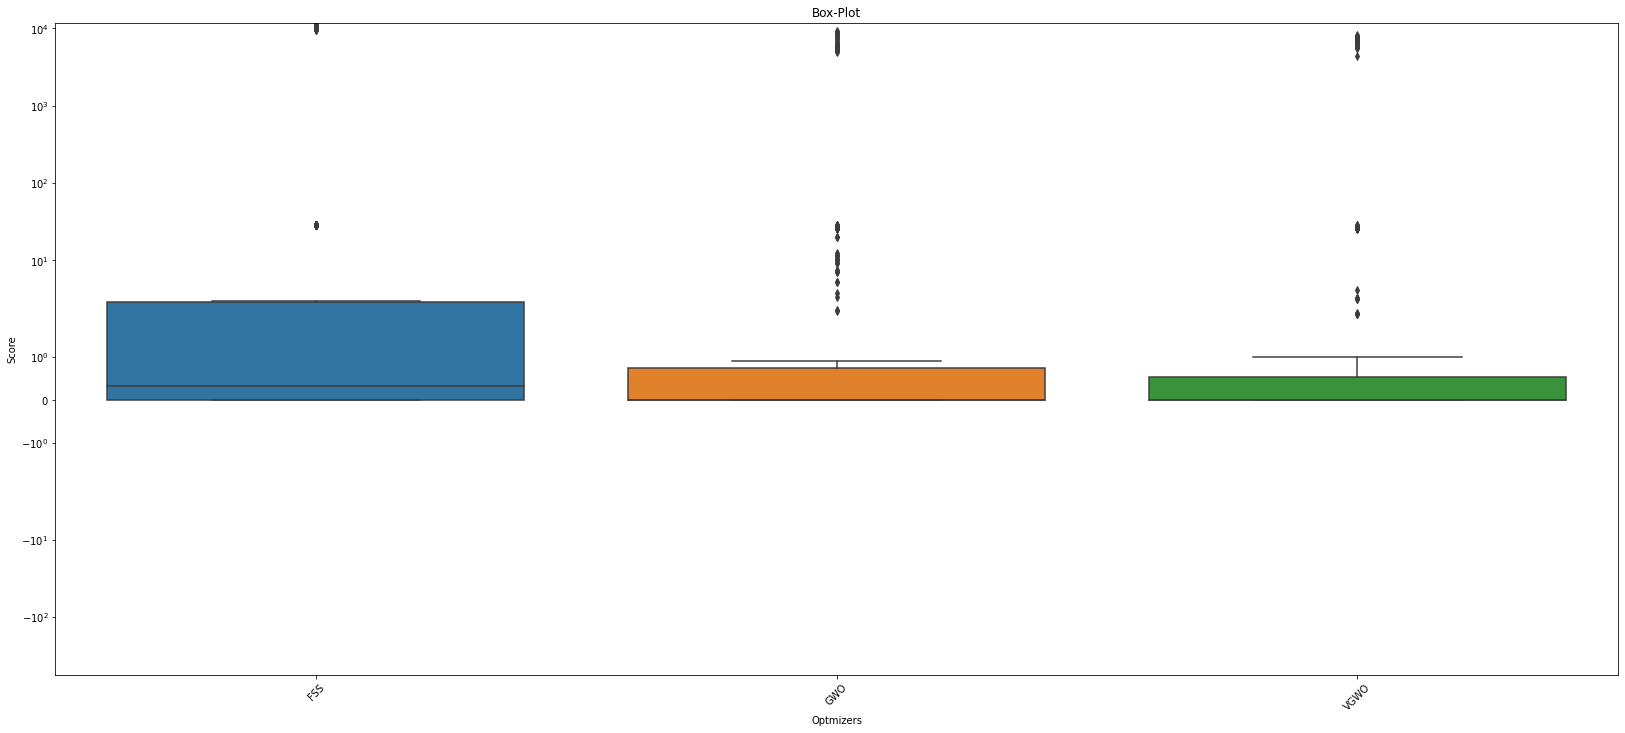

In [ ]:
objective_functions = results[30]['func'].unique().tolist()
# objective_functions.remove('Levi-13')
objective_functions.remove('Perm')
opts = results[30]['opt'].unique()
obj_show = []
for func in objective_functions:
  for o in opts[1:]:
    res = results[30][results[30]['func'] == func]
    res = res[res['opt'] == o].head(1)
    res = res.drop(['opt', 'func', 'exec_time'], axis=1)
    scores = res.values.tolist()[0]
    for s in scores:
      obj_show.append({'opt': o, 'score': s})
  
res = pd.DataFrame(data=obj_show, index=range(len(obj_show)), columns=['opt', 'score'])
# res = res[res["score"] <= 100] # remove outliers
# res = res[res["score"] >= -1000]
ax = sns.boxplot(data=res, x='opt', y='score')
ax.set_yscale('symlog')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set(xlabel= 'Optmizers', ylabel='Score', title='Box-Plot')

### Verification learning swarms in 10000 iterations

Now, for see the one execution, with 500 interation in the swarm to see the swarm evolution/learning me saved in differents files and show in graphics comparing every algoritms in the same iteration.

In [ ]:
optimizers = ["PSO", "FSS", "GWO", "VGWO"]
files_100 = []
files_50 = []
files_30 = []
files_15 = []
filepath = os.path.dirname(os.path.abspath('Results'))
for opt in optimizers:
  filename = f"{filepath}/100d/{opt}_iter.csv"
  df = pd.read_csv(filename)
  files_100.append(df)
  filename = f"{filepath}/50d/{opt}_iter.csv"
  df = pd.read_csv(filename)
  files_50.append(df)
  filename = f"{filepath}/30d/{opt}_iter.csv"
  df = pd.read_csv(filename)
  files_30.append(df)
  filename = f"{filepath}/15d/{opt}_iter.csv"
  df = pd.read_csv(filename)
  files_15.append(df)

results_15 = pd.concat(files_15)
results_15.sort_values(by=['func'], ascending=False)
results_30 = pd.concat(files_30)
results_30.sort_values(by=['func'], ascending=False)
results_50 = pd.concat(files_50)
results_50.sort_values(by=['func'], ascending=False)
results_100 = pd.concat(files_100)
results_100.sort_values(by=['func'], ascending=False)
results = {15: results_15, 30: results_30, 50: results_50, 100: results_100}
results_30.head(5)

,opt,func,exec_time,run1,run2,run3,run4,run5,run6,run7,...,run991,run992,run993,run994,run995,run996,run997,run998,run999,run1000
0,PSO,Sphere,3.748419,6.343184e+04,5.221598e+04,5.221598e+04,5.221598e+04,4.353341e+04,4.353341e+04,4.353341e+04,...,4.121625e-13,4.121625e-13,4.121625e-13,4.121625e-13,4.110931e-13,3.965455e-13,3.472293e-13,3.334590e-13,3.083056e-13,3.083056e-13
1,PSO,RotatedHyperEllipsoid,10.717805,4.484963e+05,2.850486e+05,2.850486e+05,2.850486e+05,2.850486e+05,2.259917e+05,2.105756e+05,...,4.294967e+03,4.294967e+03,4.294967e+03,4.294967e+03,4.294967e+03,4.294967e+03,4.294967e+03,4.294967e+03,4.294967e+03,4.294967e+03
2,PSO,Rosenbrock,4.322109,2.128581e+08,1.169261e+08,1.088234e+08,1.088234e+08,5.135074e+07,5.135074e+07,5.135074e+07,...,9.375896e+01,9.375873e+01,9.375761e+01,9.375761e+01,9.375392e+01,9.375339e+01,9.375215e+01,9.374679e+01,9.374679e+01,9.374455e+01
3,PSO,Dixon-Price,4.979840,6.759553e+06,3.913065e+06,3.913065e+06,3.913065e+06,3.874803e+06,2.204221e+06,1.330810e+06,...,8.100000e+01,8.100000e+01,8.100000e+01,8.100000e+01,8.100000e+01,8.100000e+01,8.100000e+01,8.100000e+01,8.100000e+01,8.100000e+01
4,PSO,Perm,46.485631,7.849214e+87,1.099002e+87,2.398840e+83,2.398840e+83,2.398840e+83,5.413475e+81,5.413475e+81,...,8.360095e-02,8.360095e-02,8.360095e-02,7.849544e-02,7.025875e-02,6.847531e-02,6.429478e-02,6.060383e-02,5.930249e-02,5.930249e-02


Functions w/ 15 dim


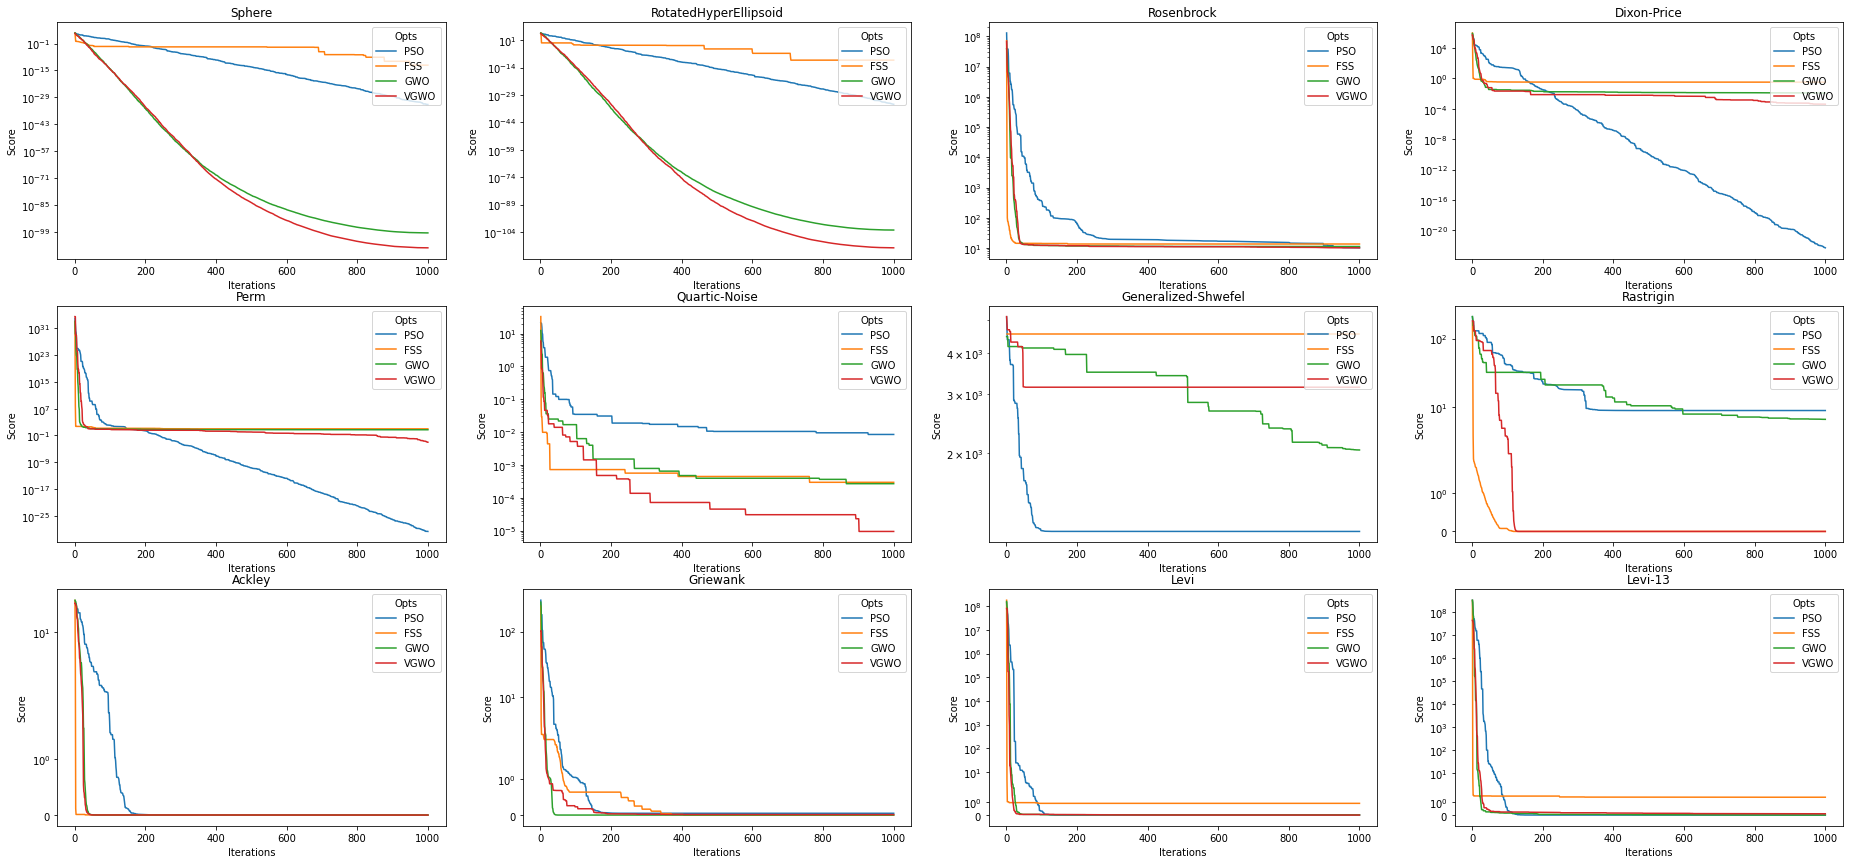

Functions w/ 30 dim


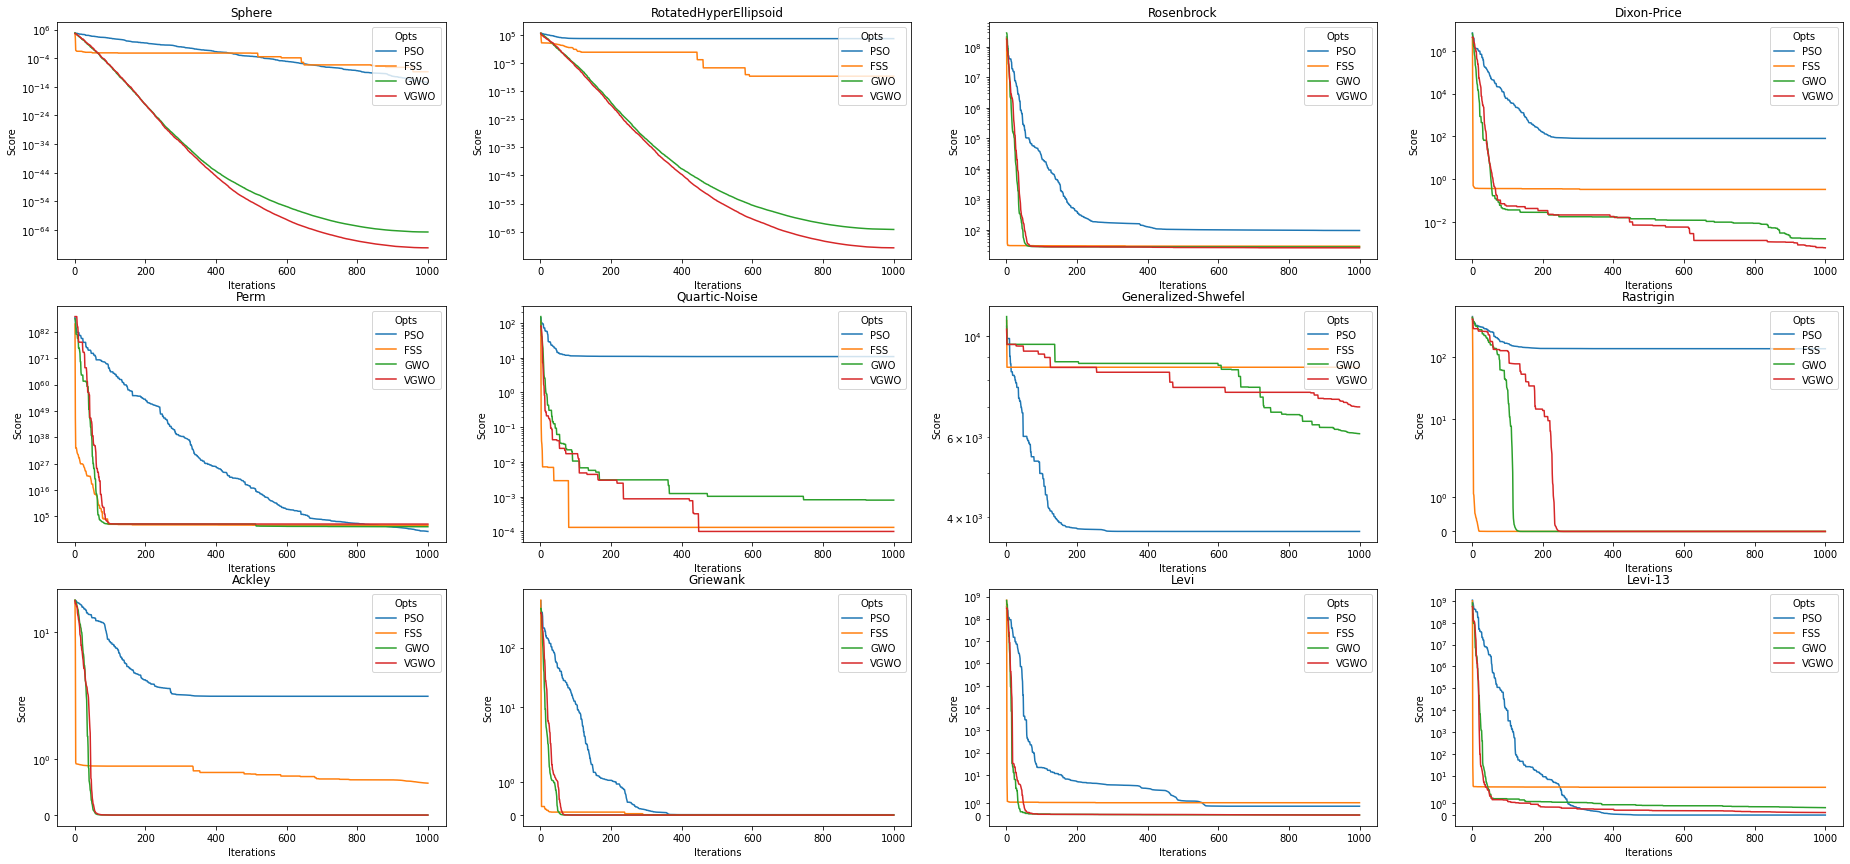

Functions w/ 50 dim


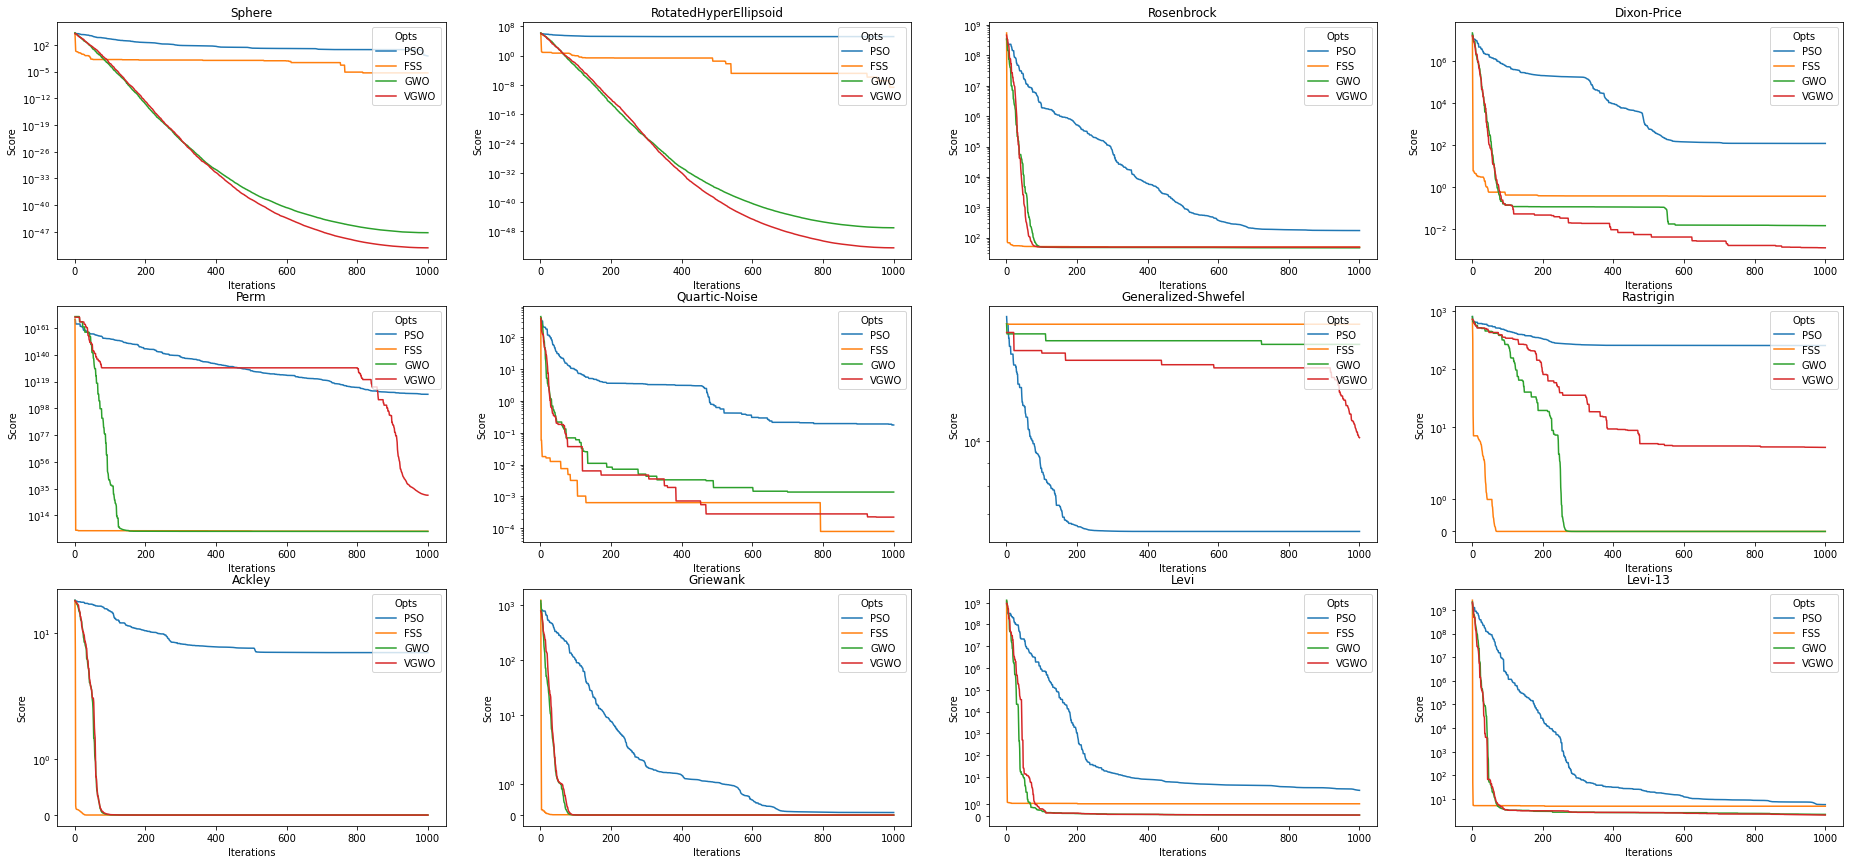

Functions w/ 100 dim


/usr/local/lib/python3.7/dist-packages/numpy/ma/core.py:6849: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


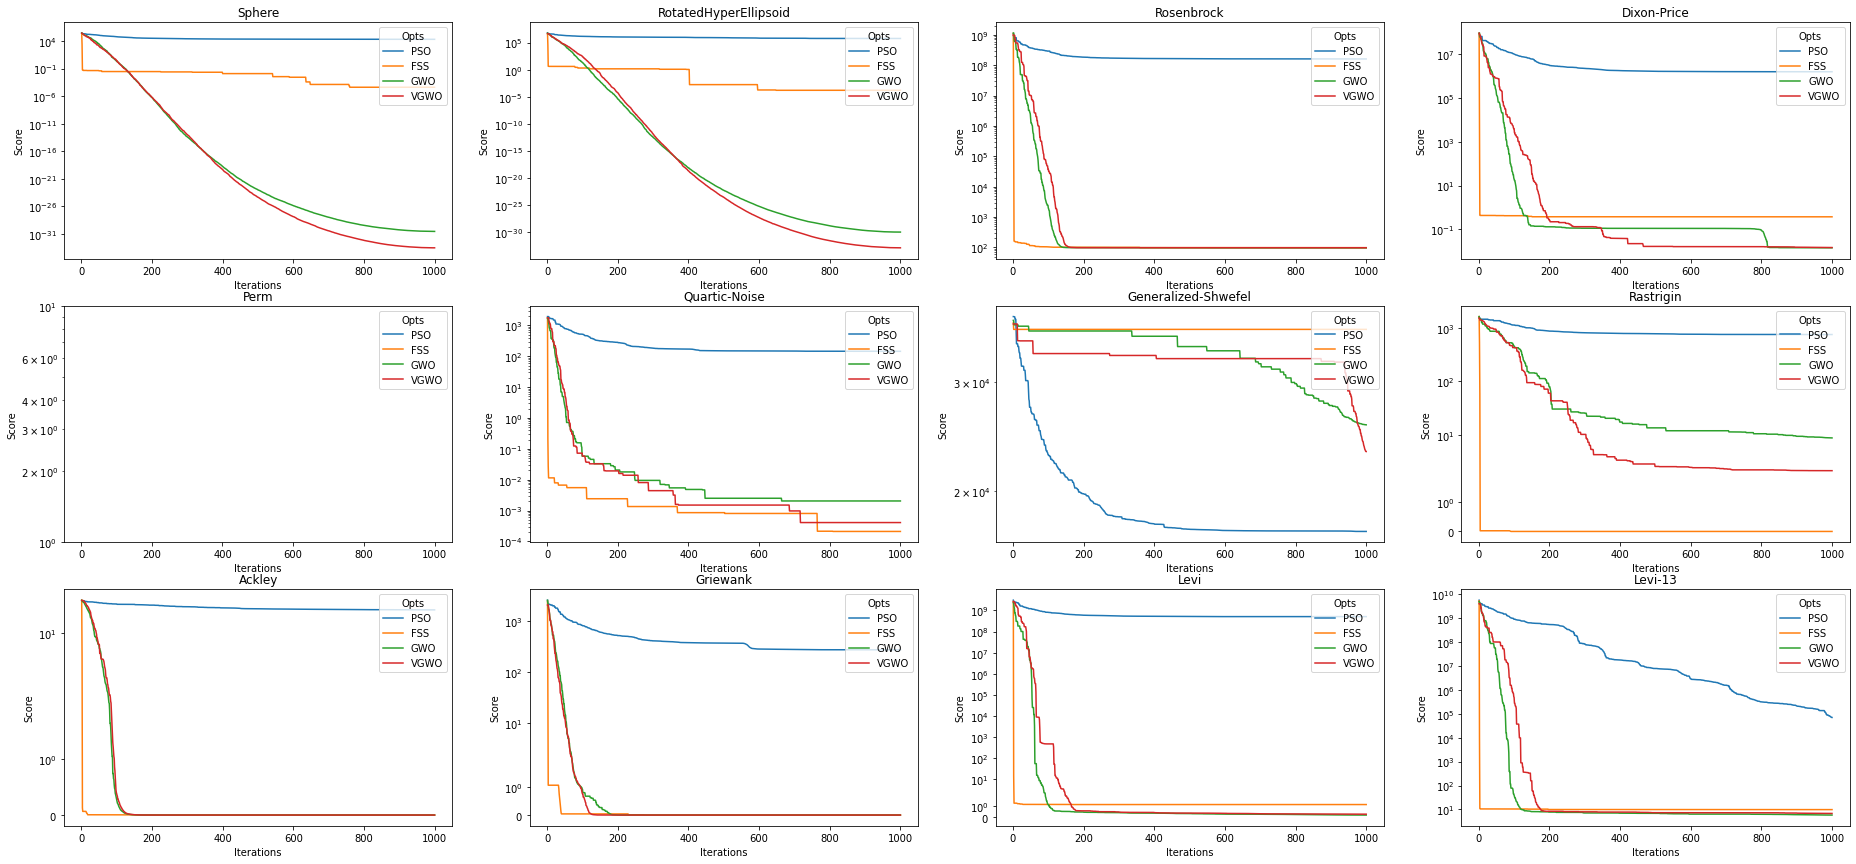

In [ ]:
plt.rcParams["figure.figsize"] = (32,20)
for d in results:
  objective_functions = results[d]['func'].unique().tolist()
  opts = results[d]['opt'].unique()
  print(f"Functions w/ {d} dim")
  for i, func in enumerate(objective_functions):
    plt.subplot(4, 4, i+1)
    for o in opts:
      res = results[d][results[d]['func'] == func]
      res = res[res['opt'] == o].head(1)
      res = res.drop(['opt', 'func', 'exec_time'], axis=1)
      y = res.values.tolist()[0][:1000]
      min_y = np.inf
      new_y = []
      for v in y:
        if v < min_y:
          min_y = v
        new_y.append(min_y)
      y = new_y
      dt = pd.DataFrame(data=y, index=range(1, len(y)+1), columns=['score'])
      plt.plot(dt, label=o)
      plt.yscale('symlog' if i > 6 else 'log')
      plt.legend(loc='upper right', title="Opts")
    plt.title(func)
    plt.xlabel('Iterations')
    plt.ylabel('Score')
  plt.show()

### Verification steps volutives (15 dim)

Validate fitness curve in 300 interations

In [ ]:
steps = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.4]
files = []
filepath = os.path.dirname(os.path.abspath('Results'))
for s in steps:
  filename = f"{filepath}/VGWO-vol/{s}-vol.csv"
  df = pd.read_csv(filename)
  files.append(df)

results = pd.concat(files)
results.sort_values(by=['func'], ascending=False)
results.head(5)

,step_vol,func,exec_time,run1,run2,run3,run4,run5,run6,run7,...,run991,run992,run993,run994,run995,run996,run997,run998,run999,run1000
0,0.0001,Sphere,6.028739,1.803398e+04,1.307701e+04,7.015278e+03,3.662130e+03,3.472752e+03,1.810558e+03,1.200103e+03,...,7.544660e-113,7.517749e-113,7.505093e-113,7.478663e-113,7.458502e-113,7.445910e-113,7.433411e-113,7.422631e-113,7.417510e-113,7.414936e-113
1,0.0001,RotatedHyperEllipsoid,11.293917,4.670958e+04,4.631147e+04,2.500921e+04,1.754643e+04,1.002394e+04,8.989965e+03,5.853985e+03,...,2.845207e-114,2.832158e-114,2.819717e-114,2.811975e-114,2.804430e-114,2.799853e-114,2.795980e-114,2.792942e-114,2.790595e-114,2.789364e-114
2,0.0001,Rosenbrock,6.230561,3.700848e+07,2.751740e+07,2.282312e+07,1.977087e+07,1.283394e+06,1.282687e+06,6.131845e+05,...,1.219199e+01,1.219199e+01,1.219199e+01,1.219199e+01,1.219197e+01,1.219197e+01,1.219197e+01,1.219197e+01,1.219195e+01,1.219195e+01
3,0.0001,Dixon-Price,6.523770,6.764449e+05,4.307344e+05,1.364083e+05,1.165646e+05,2.206885e+04,2.206885e+04,1.238901e+04,...,1.357889e-03,1.357889e-03,1.352997e-03,1.352997e-03,1.352997e-03,1.351607e-03,1.351607e-03,1.351332e-03,1.351188e-03,1.350970e-03
4,0.0001,Perm,23.570181,1.008918e+32,1.772870e+32,2.539865e+30,2.466094e+29,6.235147e+28,1.797059e+23,7.153646e+22,...,8.362079e-01,8.320007e-01,8.294746e-01,8.277998e-01,8.248215e-01,8.234103e-01,8.234103e-01,8.222925e-01,8.219737e-01,8.215591e-01


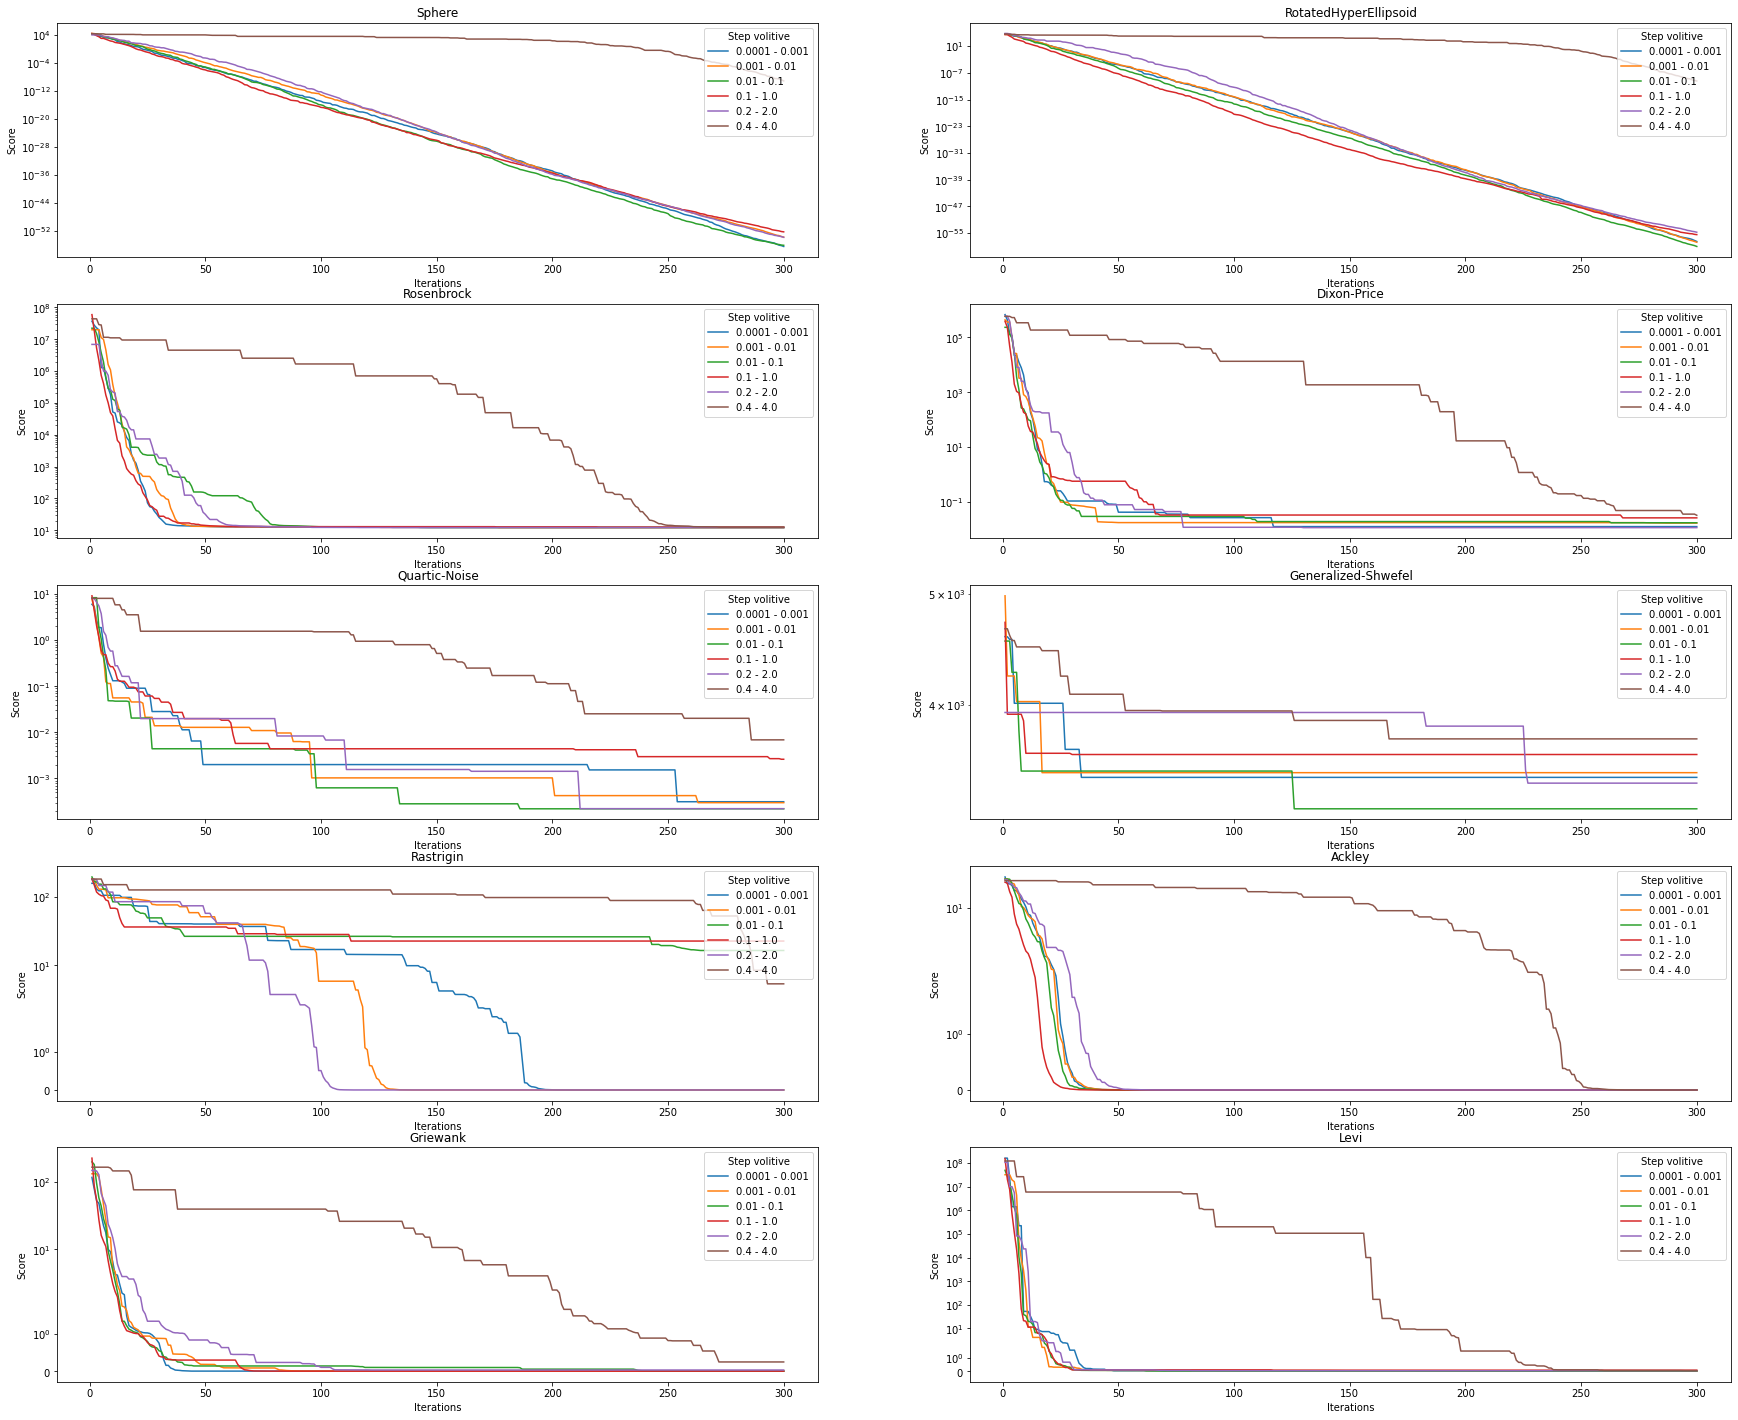

In [ ]:
plt.rcParams["figure.figsize"] = (30,25)
objective_functions = results['func'].unique().tolist()
objective_functions.remove('Levi-13')
objective_functions.remove('Perm')
steps = results['step_vol'].unique()
for i, func in enumerate(objective_functions):
  # if func in ['Perm', 'Levi-13']:
  #   continue
  plt.subplot(5, 2, i+1)
  for s in steps:
    res = results[results['func'] == func]
    res = res[res['step_vol'] == s].head(1)
    res = res.drop(['step_vol', 'func', 'exec_time'], axis=1)
    y = res.values.tolist()[0][:300]
    min_y = np.inf
    new_y = []
    for v in y:
      if v < min_y:
        min_y = v
      new_y.append(min_y)
    y = new_y
    dt = pd.DataFrame(data=y, index=range(1, len(y)+1), columns=['score'])
    plt.plot(dt, label=f"{s} - {s*10}")
    plt.legend(loc='upper right', title='Step volitive')
    plt.yscale('symlog' if i > 5 else 'log')
  plt.title(func)
  plt.xlabel('Iterations')
  plt.ylabel('Score')
  # plt.text(0, 0, string.ascii_uppercase[i], size=20, weight='bold')
plt.show()

Validation fitness variance in 30 executions

In [ ]:
steps = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.4]
files = []
filepath = os.path.dirname(os.path.abspath('Results'))
for s in steps:
  filename = f"{filepath}/VGWO-vol/VGWO_exec_{s}.csv"
  df = pd.read_csv(filename)
  files.append(df)

results = pd.concat(files)
results.sort_values(by=['func'], ascending=False)
results.head(5)

,step_vol,func,exec_time,run1,run2,run3,run4,run5,run6,run7,...,run21,run22,run23,run24,run25,run26,run27,run28,run29,run30
0,0.0001,Sphere,183.075283,2.953736e-110,1.560956e-110,8.793494e-112,7.989284e-110,2.873316e-112,1.813784e-110,6.213114e-112,...,2.095413e-107,4.761173e-111,4.934290e-111,4.632698e-111,1.128050e-110,3.639504e-110,1.910449e-109,5.663042e-109,6.624650e-110,1.177638e-113
1,0.0001,RotatedHyperEllipsoid,356.493430,4.488008e-116,1.094382e-112,4.020697e-114,1.960151e-117,3.323796e-114,5.833924e-115,7.238146e-115,...,1.106998e-116,6.083285e-115,1.747310e-117,2.960482e-113,5.056102e-115,1.477408e-113,1.552887e-117,4.880523e-114,2.449435e-116,2.730444e-114
2,0.0001,Rosenbrock,194.060201,1.127030e+01,1.111341e+01,1.117517e+01,1.012839e+01,1.218149e+01,1.033207e+01,1.022527e+01,...,1.010222e+01,1.124917e+01,1.133177e+01,1.125834e+01,1.125345e+01,1.044037e+01,1.124161e+01,1.022738e+01,1.126622e+01,1.040055e+01
3,0.0001,Dixon-Price,202.581956,4.182781e-03,6.725961e-03,5.319469e-04,2.757590e-04,1.113707e-03,2.271861e-04,5.495878e-04,...,9.439003e-04,1.058551e-03,4.583363e-04,8.832870e-04,7.954616e-03,1.006471e-03,7.953487e-04,8.919384e-04,1.024717e-02,8.981225e-04
4,0.0001,Perm,726.114071,1.147980e+00,1.116629e+00,7.610498e-04,3.225389e-04,1.211040e-03,2.162606e+00,3.272408e+00,...,1.916494e+00,1.139532e+00,3.947651e+00,2.084510e+00,1.737121e-03,1.528695e+00,1.120527e+00,2.376328e+00,2.188169e+00,8.197861e-04


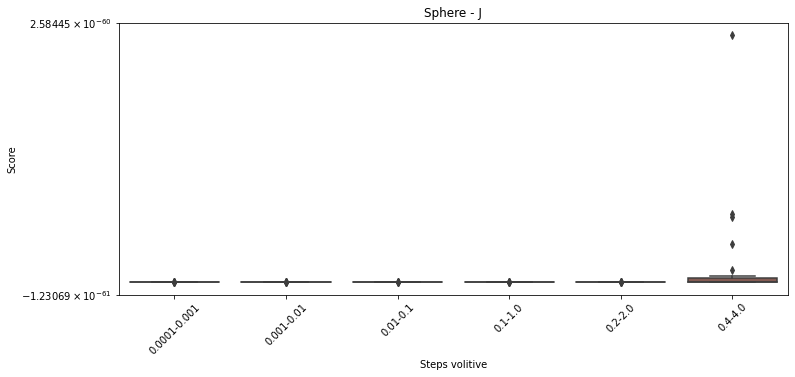

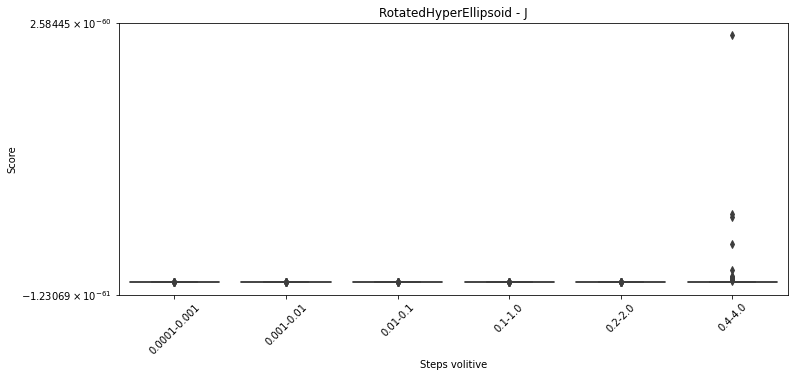

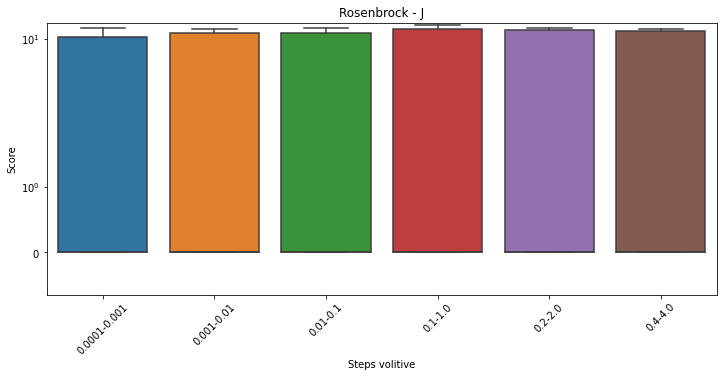

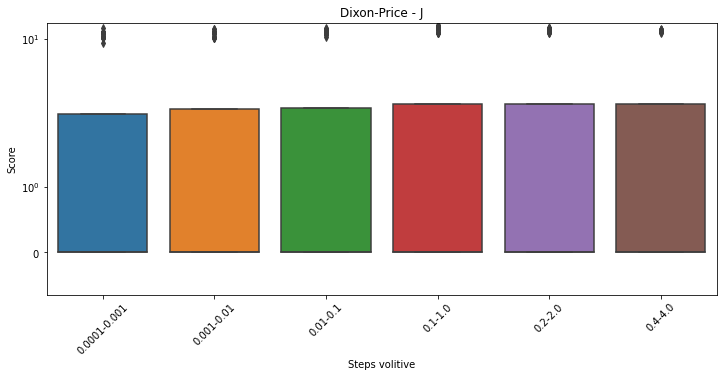

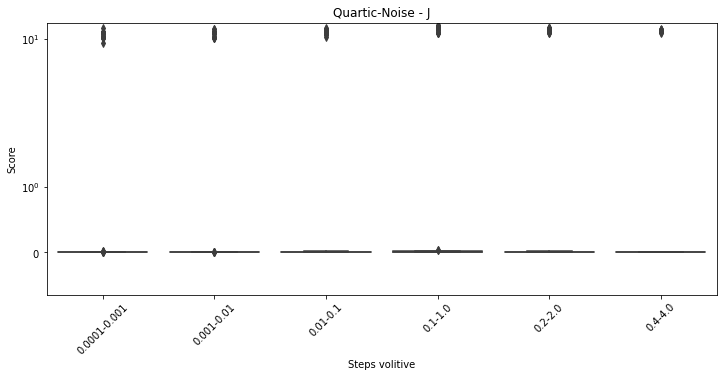

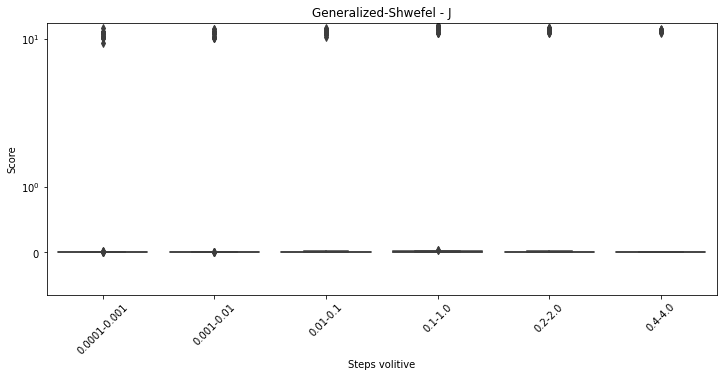

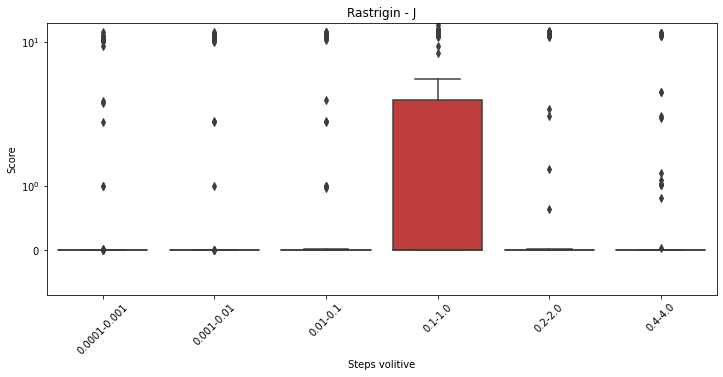

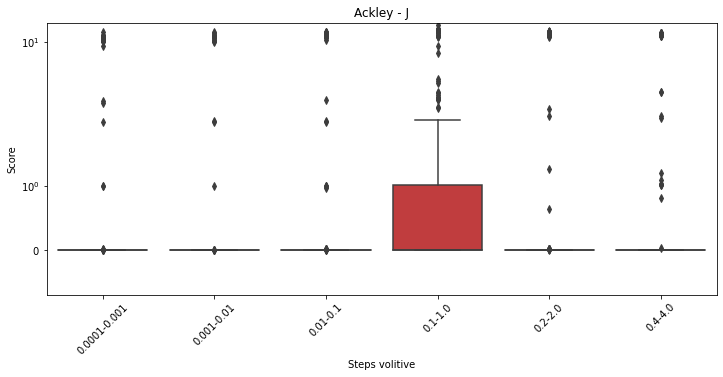

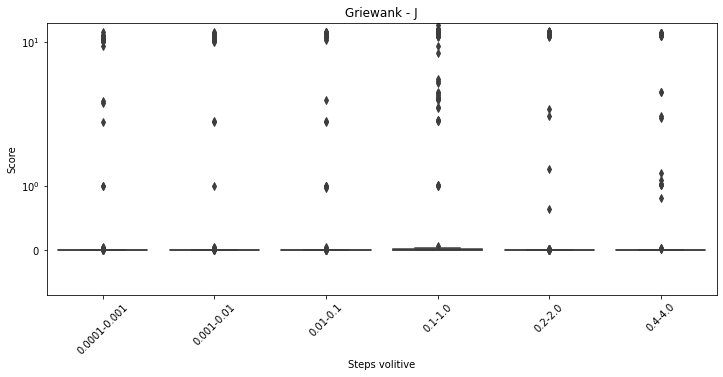

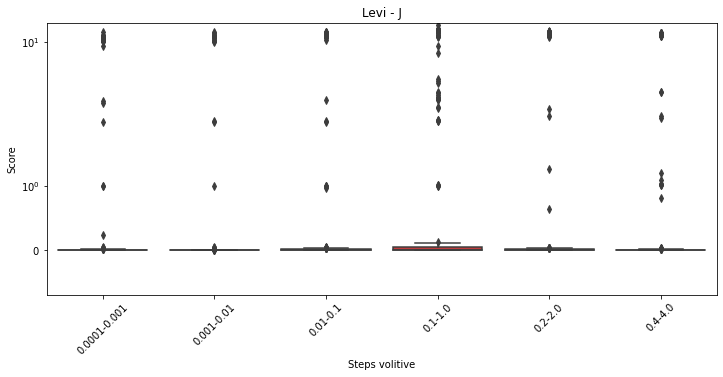

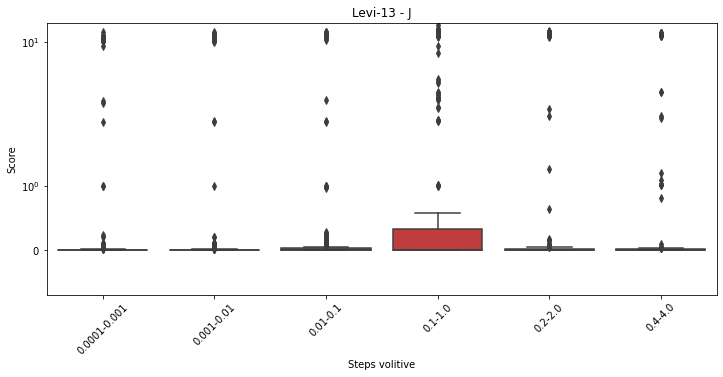

In [ ]:
plt.rcParams["figure.figsize"] = (12,5)
tb_dt = {}
objective_functions = results['func'].unique().tolist()
# objective_functions.remove('Levi-13')
objective_functions.remove('Perm')
steps_vol = results['step_vol'].unique()
obj_show = []
for func in objective_functions:
  tb_dt[func] = {}
  for v in steps_vol:
    res = results[results['func'] == func]
    res = res[res['step_vol'] == v].head(1)
    res = res.drop(['step_vol', 'func', 'exec_time'], axis=1)
    scores = res.values.tolist()[0]
    tb_dt[func][v] = scores
    for s in scores:
      obj_show.append({'step': f"{v}-{v*10}", 'score': s})
  
  res = pd.DataFrame(data=obj_show, index=range(len(obj_show)), columns=['step', 'score'])
  res = res[res["score"] <= 60] # remove outliers
  # res = res[res["score"] >= -1000]
  ax = sns.boxplot(data=res, x='step', y='score')
  ax.set_yscale('symlog')
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
  ax.set(xlabel='Steps volitive', ylabel='Score', title=f"{func} - {string.ascii_uppercase[i]}")
  plt.show()

In [ ]:
dt_func = []
for func in tb_dt:
  print(f"{func}")
  for v in tb_dt[func]:
    vols = list(tb_dt[func].keys())
    size_tb = len(tb_dt[func][v])
    lines = [[tb_dt[func][vol][i] for vol in vols] for i in range(size_tb)]
    dt = pd.DataFrame(data=lines, index=range(1, len(tb_dt[func][v])+1), columns=vols)
    dt_func.append(dt)

  # print(dt.describe())
  # print()
  display(dt.describe().loc[:].style.highlight_min(axis=1, props='color:white; font-weight:bold; background-color:green;'))

Sphere


,0.0001,0.001,0.01,0.1,0.2,0.4
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
std,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


RotatedHyperEllipsoid


,0.0001,0.001,0.01,0.1,0.2,0.4
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
std,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Rosenbrock


,0.0001,0.001,0.01,0.1,0.2,0.4
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,10.809784,11.076631,11.440043,12.092359,11.949620,11.651708
std,0.612694,0.495373,0.421140,0.514889,0.341715,0.187674
min,9.209334,10.031255,10.330326,11.081088,11.114621,11.146600
25%,10.266436,11.096012,11.233114,12.078174,11.932647,11.579266
50%,11.148560,11.230384,11.263037,12.166579,12.108861,11.662953
75%,11.252383,11.265639,11.752157,12.299751,12.159031,11.753834
max,12.181491,12.176121,12.266596,12.958583,12.319058,11.972331


Dixon-Price


,0.0001,0.001,0.01,0.1,0.2,0.4
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.002318,0.001651,0.004413,0.007673,0.005899,0.003321
std,0.003089,0.002017,0.003986,0.008217,0.004361,0.001985
min,0.000083,0.000232,0.000018,0.000259,0.000417,0.000485
25%,0.000713,0.000881,0.000980,0.001026,0.001241,0.001428
50%,0.000953,0.000912,0.003653,0.006019,0.005992,0.003167
75%,0.001176,0.001037,0.008378,0.010304,0.009750,0.005021
max,0.010545,0.008881,0.010530,0.031411,0.014275,0.007181


Quartic-Noise


,0.0001,0.001,0.01,0.1,0.2,0.4
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.000056,0.000050,0.000050,0.000182,0.000105,0.000452
std,0.000080,0.000041,0.000047,0.000171,0.000098,0.000371
min,0.000002,0.000001,0.000001,0.000023,0.000005,0.000027
25%,0.000013,0.000019,0.000018,0.000075,0.000032,0.000124
50%,0.000031,0.000035,0.000037,0.000115,0.000081,0.000359
75%,0.000048,0.000089,0.000077,0.000200,0.000129,0.000675
max,0.000353,0.000140,0.000218,0.000737,0.000422,0.001429


Generalized-Shwefel


,0.0001,0.001,0.01,0.1,0.2,0.4
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,2790.187215,2909.167937,2497.860451,2648.648247,2685.825053,2775.595734
std,404.447504,383.205715,327.759043,444.723176,327.985020,328.410674
min,1776.724230,2172.848169,1799.481322,1434.709030,1817.155597,1994.696009
25%,2554.986312,2575.686468,2221.821859,2576.927547,2533.699974,2599.189013
50%,2828.810959,2849.619917,2543.020946,2740.613573,2758.644749,2812.164398
75%,3049.089623,3247.127388,2707.776230,2916.613995,2901.518178,2981.696025
max,3337.457420,3580.719893,3062.802976,3353.623372,3137.866829,3304.400202


Rastrigin


,0.0001,0.001,0.01,0.1,0.2,0.4
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.334020,0.167908,0.370753,3.518666,0.226060,0.634225
std,0.846595,0.535442,0.781403,3.405471,0.653761,1.054467
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.274556,0.000000,0.000000
50%,0.000000,0.000000,0.000000,3.158368,0.000000,0.000000
75%,0.000000,0.000000,0.000000,3.626026,0.000000,1.026726
max,3.046225,2.039047,3.118890,13.931305,2.619236,3.690814


Ackley


,0.0001,0.001,0.01,0.1,0.2,0.4
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
std,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Griewank


,0.0001,0.001,0.01,0.1,0.2,0.4
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.013358,0.008586,0.001808,0.000000,0.000000,0.002418
std,0.015315,0.013537,0.007836,0.000000,0.000000,0.008344
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.009254,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.018261,0.012792,0.000000,0.000000,0.000000,0.000000
max,0.054680,0.049766,0.041399,0.000000,0.000000,0.040046


Levi


,0.0001,0.001,0.01,0.1,0.2,0.4
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.012453,0.008688,0.022562,0.048414,0.020866,0.007537
std,0.044113,0.009508,0.010281,0.029012,0.009452,0.006760
min,0.000000,0.000000,0.003994,0.000001,0.007625,0.002028
25%,0.000001,0.000001,0.015810,0.029490,0.012050,0.002978
50%,0.000002,0.006542,0.021463,0.040382,0.018203,0.004464
75%,0.013043,0.013433,0.026373,0.054736,0.027493,0.010338
max,0.242992,0.028194,0.047480,0.124686,0.038623,0.025040


Levi-13


,0.0001,0.001,0.01,0.1,0.2,0.4
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.030162,0.058774,0.147221,0.369876,0.067751,0.022406
std,0.053549,0.064823,0.060821,0.098368,0.036816,0.018568
min,0.000002,0.000001,0.049802,0.206573,0.018073,0.005789
25%,0.000004,0.000005,0.096729,0.314590,0.044335,0.012933
50%,0.000008,0.049567,0.137635,0.353399,0.057652,0.016367
75%,0.074186,0.100582,0.191776,0.428294,0.082341,0.025790
max,0.197147,0.210870,0.281512,0.578635,0.167039,0.100740
